installed dbplyr", version = "2.3.4" because of error in the last version

In [1]:
setwd('/home/thlamp/tcga/bladder_results')

In [2]:
library(TCGAbiolinks)
library(SummarizedExperiment)
library(sesameData)
library(sesame)
library(dbplyr)
library(ggplot2)
library(survminer)
library(pheatmap)
library(dplyr)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

# mRNA

In [6]:
# Download only these cases that are about TP ορ ΝΤ

query <- GDCquery(project = "TCGA-BLCA",data.category = "Transcriptome Profiling",data.type = "Gene Expression Quantification", 
    workflow.type = "STAR - Counts", access = "open", sample.type = c("Primary Tumor","Solid Tissue Normal"))

GDCdownload(query = query)

dataPrep <- GDCprepare(query = query,save = TRUE)

# Which samples are Primary Tumor
samples.primary.tumour <- dataPrep$barcode[dataPrep$shortLetterCode == "TP"]

# which samples are solid tissue normal
samples.solid.tissue.normal <- dataPrep$barcode[dataPrep$shortLetterCode == "NT"]

saveRDS(dataPrep, file = "downloaded_dataPrep.rds")
saveRDS(samples.primary.tumour,"samples_primary_tumour.rds")
saveRDS(samples.solid.tissue.normal,"samples_solid_tissue_normal.rds")

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--------------------

ooo By access

ooo By data.type

ooo By workflow.type

ooo By sample.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------


Of the 431 files for download 431 already exist.

All samples have been already downloaded



|====================================================|100%                      Completed after 26 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

blca subtype information from:doi:10.1016/j.cell.2017.09.007

Available assays in SummarizedExperiment : 
  => unstranded
  => stranded_first
  => stranded_second
  => tpm_unstrand
  => fpkm_unstrand
  => fpkm_uq_unstrand

=> Saving file: TCGA-BLCATranscriptome_ProfilingWed_Nov_22_17:21:31_2023.RData

=> File saved



In [3]:
# samples.primary.tumour <- readRDS("samples_primary_tumour.rds")
# samples.solid.tissue.normal <- readRDS("samples_solid_tissue_normal.rds")
dataPrep <- readRDS("downloaded_dataPrep.rds")

In [4]:
dataPrep

class: RangedSummarizedExperiment 
dim: 60660 431 
metadata(1): data_release
assays(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand
rownames(60660): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000288674.1 ENSG00000288675.1
rowData names(10): source type ... hgnc_id havana_gene
colnames(431): TCGA-E7-A678-01A-11R-A30C-07
  TCGA-UY-A9PB-01A-11R-A38B-07 ... TCGA-FD-A6TH-01A-11R-A32O-07
  TCGA-BT-A20T-01A-11R-A14Y-07
colData names(238): barcode patient ... paper_Fusion in TNFRSF21
  paper_Fusion in ASIP

## Raw data

In [5]:
data_matrix <- TCGAanalyze_Preprocessing(object = dataPrep,datatype = "unstranded") 
# saveRDS(data_matrix,"raw_data_matrix.rds")

Number of outliers: 0



In [6]:
head(data_matrix)

,TCGA-2F-A9KO-01A-11R-A38B-07,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-2F-A9KQ-01A-11R-A38B-07,TCGA-2F-A9KR-01A-11R-A38B-07,TCGA-2F-A9KT-01A-11R-A38B-07,TCGA-2F-A9KW-01A-11R-A38B-07,TCGA-4Z-AA7M-01A-11R-A39I-07,TCGA-4Z-AA7N-01A-11R-A39I-07,TCGA-4Z-AA7O-01A-31R-A39I-07,TCGA-4Z-AA7Q-01A-11R-A39I-07,⋯,TCGA-CU-A0YR-11A-13R-A10U-07,TCGA-GC-A3BM-11A-11R-A22U-07,TCGA-GC-A3WC-11A-11R-A22U-07,TCGA-GC-A6I3-11A-11R-A31N-07,TCGA-GD-A2C5-11A-11R-A180-07,TCGA-GD-A3OP-11A-11R-A220-07,TCGA-GD-A3OQ-11A-21R-A220-07,TCGA-K4-A3WV-11A-21R-A22U-07,TCGA-K4-A54R-11A-11R-A26T-07,TCGA-K4-A5RI-11A-11R-A28M-07
ENSG00000000003.15,6074,11615,5414,4368,3313,2648,8417,2536,7920,3733,⋯,1407,4122,2205,3553,13687,10006,10494,9246,4371,3390
ENSG00000000005.6,0,4,1,1,0,0,4,2,0,0,⋯,42,6,12,0,5,3,4,6,11,5
ENSG00000000419.13,3065,2649,1977,2053,2920,2037,2682,1096,1160,1292,⋯,1013,1560,1219,1206,2765,2472,1832,1556,1576,1857
ENSG00000000457.14,1085,821,971,872,410,514,1014,279,806,880,⋯,499,368,505,375,580,645,1250,747,310,569
ENSG00000000460.17,688,819,365,334,272,859,1553,163,676,440,⋯,113,174,114,367,350,159,272,265,121,88
ENSG00000000938.13,436,115,310,584,361,339,175,420,255,704,⋯,460,472,444,777,1061,999,693,322,558,1594


## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [9]:
duplicates_index_to_remove <- function(patient,input_matrix) {
  # for every element in patient search colnames that start with this sample id, whih are from duplicated samples 
  duplicated_columns <- colnames(input_matrix)[grep(patient, colnames(input_matrix))]
    
  # Count zeros in the specified columns
  zero_counts <- colSums(input_matrix[, duplicated_columns] == 0)
  print(zero_counts)

  # find which column for every duplicated sample has more zeros
  index_of_larger_number <- which.max(zero_counts)

  # Find the index from the matrix, of the column with more zeros to remove
  column_index_to_remove <- which(colnames(input_matrix) %in% duplicated_columns[index_of_larger_number])

  return (column_index_to_remove)
}

In [10]:
# find duplicated samples in colData(dataPrep)
patient_duplicates <- colData(dataPrep)$sample[which(duplicated(colData(dataPrep)$sample))]

# use function duplicates_index_to_remove for every element in patient_duplicates
patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove, input_matrix = data_matrix)

patient_duplicates_to_remove
colnames(data_matrix)[patient_duplicates_to_remove]

TCGA-BL-A13I-01A-11R-A13Y-07 TCGA-BL-A13I-01A-11R-A277-07 
                       31291                        39927 
TCGA-BL-A0C8-01A-11R-A10U-07 TCGA-BL-A0C8-01A-11R-A277-07 
                       29242                        23308 
TCGA-BL-A13J-01A-11R-A10U-07 TCGA-BL-A13J-01A-11R-A277-07 
                       31629                        22987 


TCGA-BL-A13I-01A TCGA-BL-A0C8-01A TCGA-BL-A13J-01A 
              29               25               31

[1] "TCGA-BL-A13I-01A-11R-A277-07" "TCGA-BL-A0C8-01A-11R-A10U-07"
[3] "TCGA-BL-A13J-01A-11R-A10U-07"

In [11]:
# Remove the specified-duplicated columns
data_matrix <- data_matrix[, -patient_duplicates_to_remove, drop = FALSE]
dim(data_matrix)

[1] 60660   428

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [67]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(data_matrix, 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 3141

### A matrix in R can only hold one type of data, if first element is integer, then all the elements in this matrix are integers

In [7]:
typeof(data_matrix[1,1])

[1] "integer"

## dataPrep metadata

In [14]:
# see information that are related with columns
colData(dataPrep)

DataFrame with 431 rows and 238 columns
                                            barcode      patient
                                        <character>  <character>
TCGA-E7-A678-01A-11R-A30C-07 TCGA-E7-A678-01A-11R.. TCGA-E7-A678
TCGA-UY-A9PB-01A-11R-A38B-07 TCGA-UY-A9PB-01A-11R.. TCGA-UY-A9PB
TCGA-DK-A3IN-01A-11R-A20F-07 TCGA-DK-A3IN-01A-11R.. TCGA-DK-A3IN
TCGA-DK-A3IV-01A-22R-A21D-07 TCGA-DK-A3IV-01A-22R.. TCGA-DK-A3IV
TCGA-XF-A9T4-01A-11R-A39I-07 TCGA-XF-A9T4-01A-11R.. TCGA-XF-A9T4
...                                             ...          ...
TCGA-DK-AA6X-01A-12R-A42T-07 TCGA-DK-AA6X-01A-12R.. TCGA-DK-AA6X
TCGA-E7-A8O7-01A-11R-A36F-07 TCGA-E7-A8O7-01A-11R.. TCGA-E7-A8O7
TCGA-E7-A7PW-01A-11R-A352-07 TCGA-E7-A7PW-01A-11R.. TCGA-E7-A7PW
TCGA-FD-A6TH-01A-11R-A32O-07 TCGA-FD-A6TH-01A-11R.. TCGA-FD-A6TH
TCGA-BT-A20T-01A-11R-A14Y-07 TCGA-BT-A20T-01A-11R.. TCGA-BT-A20T
                                       sample shortLetterCode
                                  <character>     <ch

In [20]:
#take all the information that are related with rows
head(rowData(dataPrep))
row_data<-rowData(dataPrep)

DataFrame with 6 rows and 10 columns
                     source     type     score     phase            gene_id
                   <factor> <factor> <numeric> <integer>        <character>
ENSG00000000003.15   HAVANA     gene        NA        NA ENSG00000000003.15
ENSG00000000005.6    HAVANA     gene        NA        NA  ENSG00000000005.6
ENSG00000000419.13   HAVANA     gene        NA        NA ENSG00000000419.13
ENSG00000000457.14   HAVANA     gene        NA        NA ENSG00000000457.14
ENSG00000000460.17   HAVANA     gene        NA        NA ENSG00000000460.17
ENSG00000000938.13   HAVANA     gene        NA        NA ENSG00000000938.13
                        gene_type   gene_name       level     hgnc_id
                      <character> <character> <character> <character>
ENSG00000000003.15 protein_coding      TSPAN6           2  HGNC:11858
ENSG00000000005.6  protein_coding        TNMD           2  HGNC:17757
ENSG00000000419.13 protein_coding        DPM1           2   HGNC:3005
ENSG0

## TPM

In [12]:
data_matrix <- TCGAanalyze_Preprocessing(object = dataPrep,datatype = "tpm_unstrand") 

Number of outliers: 0



In [6]:
saveRDS(data_matrix, file = "data_matrix.rds")

In [13]:
data_matrix <- readRDS("data_matrix.rds")

In [14]:
head(data_matrix)

,TCGA-2F-A9KO-01A-11R-A38B-07,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-2F-A9KQ-01A-11R-A38B-07,TCGA-2F-A9KR-01A-11R-A38B-07,TCGA-2F-A9KT-01A-11R-A38B-07,TCGA-2F-A9KW-01A-11R-A38B-07,TCGA-4Z-AA7M-01A-11R-A39I-07,TCGA-4Z-AA7N-01A-11R-A39I-07,TCGA-4Z-AA7O-01A-31R-A39I-07,TCGA-4Z-AA7Q-01A-11R-A39I-07,⋯,TCGA-CU-A0YR-11A-13R-A10U-07,TCGA-GC-A3BM-11A-11R-A22U-07,TCGA-GC-A3WC-11A-11R-A22U-07,TCGA-GC-A6I3-11A-11R-A31N-07,TCGA-GD-A2C5-11A-11R-A180-07,TCGA-GD-A3OP-11A-11R-A220-07,TCGA-GD-A3OQ-11A-21R-A220-07,TCGA-K4-A3WV-11A-21R-A22U-07,TCGA-K4-A54R-11A-11R-A26T-07,TCGA-K4-A5RI-11A-11R-A28M-07
ENSG00000000003.15,108.0135,186.7056,72.4201,73.9806,76.9549,49.0722,159.5696,69.2064,155.7212,50.5693,⋯,27.3519,66.9105,39.2798,56.5882,152.7241,105.0533,125.2822,149.4164,77.8400,48.6603
ENSG00000000005.6,0.0000,0.1976,0.0411,0.0521,0.0000,0.0000,0.2330,0.1677,0.0000,0.0000,⋯,2.5092,0.2993,0.6569,0.0000,0.1715,0.0968,0.1468,0.2980,0.6020,0.2206
ENSG00000000419.13,204.8328,160.0243,99.3833,130.6741,254.8962,141.8646,191.0809,112.4019,85.7129,65.7745,⋯,74.0063,95.1648,81.6075,72.1844,115.9472,97.5357,82.1939,94.4974,105.4736,100.1734
ENSG00000000457.14,12.7153,8.6971,8.5596,9.7330,6.2762,6.2773,12.6685,5.0176,10.4437,7.8561,⋯,6.3928,3.9367,5.9285,3.9360,4.2650,4.4628,9.8345,7.9554,3.6381,5.3825
ENSG00000000460.17,9.2959,10.0028,3.7096,4.2981,4.8005,12.0951,22.3698,3.3797,10.0988,4.5288,⋯,1.6691,2.1460,1.5430,4.4411,2.9673,1.2684,2.4673,3.2538,1.6372,0.9597
ENSG00000000938.13,10.3989,2.4793,5.5616,13.2662,11.2466,8.4259,4.4497,15.3726,6.7245,12.7909,⋯,11.9936,10.2761,10.6082,16.5978,15.8787,14.0674,11.0964,6.9791,13.3277,30.6876


## Max value of matrix

In [70]:
which(data_matrix == max(data_matrix), arr.ind = TRUE)
colnames(data_matrix)[26]
data_matrix[53692,26]

,row,col
ENSG00000276168.1,53692,26


[1] "TCGA-BL-A0C8-01A-11R-A277-07"

[1] 319762.4

## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [24]:
# find duplicated samples in colData(dataPrep)
patient_duplicates <- colData(dataPrep)$sample[which(duplicated(colData(dataPrep)$sample))]

# use function duplicates_index_to_remove for every element in patient_duplicates
patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove, input_matrix = data_matrix)

patient_duplicates_to_remove
colnames(data_matrix)[patient_duplicates_to_remove]

TCGA-BL-A13I-01A-11R-A13Y-07 TCGA-BL-A13I-01A-11R-A277-07 
                       31291                        39927 
TCGA-BL-A0C8-01A-11R-A10U-07 TCGA-BL-A0C8-01A-11R-A277-07 
                       29242                        23308 
TCGA-BL-A13J-01A-11R-A10U-07 TCGA-BL-A13J-01A-11R-A277-07 
                       31629                        22987 


TCGA-BL-A13I-01A TCGA-BL-A0C8-01A TCGA-BL-A13J-01A 
              29               25               31

[1] "TCGA-BL-A13I-01A-11R-A277-07" "TCGA-BL-A0C8-01A-11R-A10U-07"
[3] "TCGA-BL-A13J-01A-11R-A10U-07"

In [25]:
# Remove the specified-duplicated columns
data_matrix <- data_matrix[, -patient_duplicates_to_remove, drop = FALSE]
dim(data_matrix)

[1] 60660   428

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [72]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(data_matrix, 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 3141

### A matrix in R can only hold one type of data, if first element is integer/double, then all the elements in this matrix are integers/doubles

In [51]:
typeof(data_matrix[1,1])

[1] "double"

## DEA

In [50]:
dataDEGs <- TCGAanalyze_DEA(mat1 = data_matrix[,samples.primary.tumour],mat2 = data_matrix[,samples.solid.tissue.normal],Cond1type = "TP",Cond2type = "NT",
   method = "glmLRT",logFC.cut = 1, fdr.cut = 0.01) 

dataDEGsFiltLevel <- TCGAanalyze_LevelTab(FC_FDR_table_mRNA = dataDEGs,typeCond1 = "Tumor",typeCond2 = "Normal",TableCond1 = data_matrix[,samples.primary.tumour],
    TableCond2 = data_matrix[,samples.solid.tissue.normal])

saveRDS(dataDEGs, file = "dataDEGs.rds")

Batch correction skipped since no factors provided

----------------------- DEA -------------------------------

o 412 samples in Cond1type TP

o 19 samples in Cond2type NT

o 60660 features as miRNA or genes 

This may take some minutes...

----------------------- END DEA -------------------------------



In [30]:
dataDEGs <- readRDS("dataDEGs.rds")

## In order to retrieve gene name and gene type I must run DEA with ensemvl ids without versions

In [44]:
head(dataDEGs)

,logFC,logCPM,LR,PValue,FDR,gene_name,gene_type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000000460.17,-1.698769,3.164774,29.27580,6.277480e-08,1.463084e-06,NA,NA
ENSG00000000971.16,1.156711,5.112667,15.70537,7.401369e-05,7.906206e-04,NA,NA
ENSG00000002079.14,-2.319153,1.411322,11.35675,7.517430e-04,5.685084e-03,NA,NA
ENSG00000002587.10,1.517898,4.124496,32.48053,1.203924e-08,3.233325e-07,NA,NA
ENSG00000003096.14,2.032876,2.184867,49.35954,2.130952e-12,1.021577e-10,NA,NA
ENSG00000003249.15,-1.801270,4.329002,24.50678,7.404887e-07,1.378418e-05,NA,NA


## Substitute ensembl ids at mRNA column with gene symbol

In [45]:
dataDEGsFiltLevel$mRNA <- apply(as.matrix(dataDEGsFiltLevel),1, function (x){
  row_data$gene_name[which(row_data$gene_id %in% x)]})

head(dataDEGsFiltLevel)

,mRNA,logFC,FDR,Delta,Tumor,Normal,start,end
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ENSG00000171401.15,KRT13,1.874307,4.076803e-03,2154.823,1149.6643,4215.352,NA,NA
ENSG00000175084.12,DES,4.345141,2.868765e-20,1910.404,439.6644,8938.345,NA,NA
ENSG00000211895.5,IGHA1,1.500368,7.001122e-03,1609.103,1072.4724,3034.252,NA,NA
ENSG00000101335.10,MYL9,3.850621,2.033738e-46,1379.842,358.3426,5171.240,NA,NA
ENSG00000128016.7,ZFP36,2.829324,7.520136e-43,1212.211,428.4455,3045.949,NA,NA
ENSG00000170345.10,FOS,3.039402,7.739025e-35,1159.465,381.4779,3137.300,NA,NA


## GO enrichment

In [58]:
Genelist <- dataDEGsFiltLevel$mRNA

ansEA <- TCGAanalyze_EAcomplete(TFname = "DEA genes Normal Vs Tumor",RegulonList = Genelist)

TCGAvisualize_EAbarplot(tf = rownames(ansEA$ResBP),GOBPTab = ansEA$ResBP,GOCCTab = ansEA$ResCC,GOMFTab = ansEA$ResMF,PathTab = ansEA$ResPat,
    nRGTab = Genelist, nBar = 10)

[1] "I need about  1 minute to finish complete  Enrichment analysis GO[BP,MF,CC] and Pathways... "
[1] "GO Enrichment Analysis BP completed....done"
[1] "GO Enrichment Analysis MF completed....done"
[1] "GO Enrichment Analysis CC completed....done"
[1] "Pathway Enrichment Analysis completed....done"


png 
  2

## Heatmap

### Take column metadata for heatmap

In [ ]:
col.metadata <- colData(dataPrep)[, c("barcode", "ajcc_pathologic_stage","shortLetterCode")]
head(col.metadata)

In [59]:
head(col.metadata)

DataFrame with 6 rows and 3 columns
                                            barcode ajcc_pathologic_stage
                                        <character>           <character>
TCGA-E7-A678-01A-11R-A30C-07 TCGA-E7-A678-01A-11R..             Stage III
TCGA-UY-A9PB-01A-11R-A38B-07 TCGA-UY-A9PB-01A-11R..             Stage III
TCGA-DK-A3IN-01A-11R-A20F-07 TCGA-DK-A3IN-01A-11R..             Stage III
TCGA-DK-A3IV-01A-22R-A21D-07 TCGA-DK-A3IV-01A-22R..              Stage II
TCGA-XF-A9T4-01A-11R-A39I-07 TCGA-XF-A9T4-01A-11R..              Stage IV
TCGA-FD-A62S-01A-11R-A30C-07 TCGA-FD-A62S-01A-11R..             Stage III
                             shortLetterCode
                                 <character>
TCGA-E7-A678-01A-11R-A30C-07              TP
TCGA-UY-A9PB-01A-11R-A38B-07              TP
TCGA-DK-A3IN-01A-11R-A20F-07              TP
TCGA-DK-A3IV-01A-22R-A21D-07              TP
TCGA-XF-A9T4-01A-11R-A39I-07              TP
TCGA-FD-A62S-01A-11R-A30C-07              TP

In [60]:
length(col.metadata$shortLetterCode)
unique(col.metadata$shortLetterCode)

[1] 431

[1] "TP" "NT"

### Create df and match barcode with shortLetterCode

In [61]:
metadata<- data.frame(shortLetterCode = col.metadata$shortLetterCode, barcode = col.metadata$barcode)
rownames(metadata) <- metadata$barcode
metadata <-metadata[order(metadata$shortLetterCode), ]
metadata <- metadata[, 1, drop = FALSE]
metadata

,shortLetterCode
,<chr>
TCGA-BT-A20R-11A-11R-A16R-07,NT
TCGA-GC-A3BM-11A-11R-A22U-07,NT
TCGA-GC-A6I3-11A-11R-A31N-07,NT
TCGA-CU-A0YR-11A-13R-A10U-07,NT
TCGA-BT-A20U-11A-11R-A14Y-07,NT
TCGA-GD-A3OP-11A-11R-A220-07,NT
TCGA-GD-A3OQ-11A-21R-A220-07,NT
TCGA-BT-A20N-11A-11R-A14Y-07,NT
TCGA-K4-A3WV-11A-21R-A22U-07,NT


### Take first 20 DEGs to plot them with heatmap (they are not ordered by FDR), and create matrix with threir values

In [63]:
degs_rnames <- rownames(dataDEGsFiltLevel)[1:20]
 # head(degs_rnames,4)
subsetted_mat <- data_matrix[rownames(data_matrix) %in% degs_rnames, ]
# head(subsetted_mat,4)
m<-t(subsetted_mat)
# head(m,4)
# reorder the matrix based in the annotation
final_mat <- m[rownames(metadata), ]
final_mat

,ENSG00000004799.8,ENSG00000022267.19,ENSG00000095303.17,ENSG00000112562.19,ENSG00000123358.20,ENSG00000124212.6,ENSG00000128591.16,ENSG00000130176.8,ENSG00000133392.18,ENSG00000159251.8,ENSG00000163017.14,ENSG00000163431.13,ENSG00000168497.5,ENSG00000172403.11,ENSG00000175084.12,ENSG00000182253.15,ENSG00000183036.11,ENSG00000188783.6,ENSG00000198848.13,ENSG00000213088.12
TCGA-BT-A20R-11A-11R-A16R-07,8.590800,9.664620,9.7461134,8.196472,8.795014,8.2036260,10.2358239,12.241293,12.221314,11.12535780,12.628436,10.103672,7.986257,9.6298915,13.9134727,10.5787922,10.3524715,7.6217200,7.0534546,8.8629885
TCGA-GC-A3BM-11A-11R-A22U-07,6.078567,6.892624,4.2450468,6.750174,10.316702,4.6788663,4.4476651,8.516263,6.945070,0.99761759,9.388754,7.077903,5.814017,5.6787959,8.0632117,4.4936794,4.7556194,5.0492866,6.2332822,6.2162802
TCGA-GC-A6I3-11A-11R-A31N-07,4.629526,4.318649,3.7645054,5.377322,6.861016,4.3896494,3.7162776,7.067775,4.906751,2.58882855,7.765787,4.411928,4.418946,3.1450089,8.6796610,3.6709649,3.4367215,3.7097869,3.1886066,9.6794354
TCGA-CU-A0YR-11A-13R-A10U-07,7.693695,9.360915,9.7367682,8.136221,8.560908,8.0732697,9.2558861,11.824306,12.063903,11.05818199,11.919795,9.862095,8.333307,8.1150197,13.2776675,9.9566544,9.9180888,8.4678228,7.7942443,9.3238764
TCGA-BT-A20U-11A-11R-A14Y-07,4.756847,6.793052,6.8218530,6.176311,5.840969,5.0886801,6.1878687,9.171776,8.954428,8.46473034,9.649784,6.963370,5.466895,5.8820243,10.5805551,7.0169520,7.0158621,5.1151165,10.5287509,5.3384743
TCGA-GD-A3OP-11A-11R-A220-07,5.525969,6.820998,5.6979100,5.402337,8.953489,4.9630163,5.7054472,8.356015,7.847989,6.63075929,9.046159,6.340936,5.527102,5.5323232,10.0415093,6.0155176,6.0743128,5.1506734,4.8197346,7.0075846
TCGA-GD-A3OQ-11A-21R-A220-07,7.149457,8.392537,7.5262747,7.296579,9.452951,7.1787087,8.2515932,10.706641,10.623932,8.94651244,11.259067,8.200483,6.639193,7.5191157,12.2851550,8.7674436,8.4887781,6.1893996,6.1777683,4.6654212
TCGA-BT-A20N-11A-11R-A14Y-07,7.606547,10.622516,9.4633063,8.226710,10.500778,8.8668468,10.8485759,12.793594,12.671754,11.30952871,13.135591,10.459432,7.811671,10.5477465,14.4546696,11.2117974,10.9350719,8.1612826,7.0899621,7.3524160
TCGA-K4-A3WV-11A-21R-A22U-07,7.144070,5.211437,5.0045104,4.892702,6.452465,4.8150374,5.7717694,8.203609,8.788686,4.09600035,8.912585,6.699621,5.824279,4.3286283,10.2191573,6.1574318,6.3008888,6.0939172,6.2483906,5.8408862
TCGA-BT-A2LB-11A-11R-A18C-07,7.214648,5.369041,4.1730315,4.531126,7.404681,2.5816405,4.2438366,6.850221,6.604930,1.18434378,7.180855,5.264634,5.995267,4.3535491,8.0037152,3.9216172,2.0331587,4.0955700,5.0328194,6.6856094


In [64]:
dim(final_mat)

[1] 431  20

### Heatmap for TP/NT with scaling per row (per gene)

### from tcga heatmap. If we want to show differences between genes, it is good to make Z-score by samples (force each sample to have zero mean and standard deviation=1). If we want to show differences between samples, it is good to make Z-score by genes (force each gene to have zero mean and standard deviation=1). Possibilities: "row", "col". Default "none"

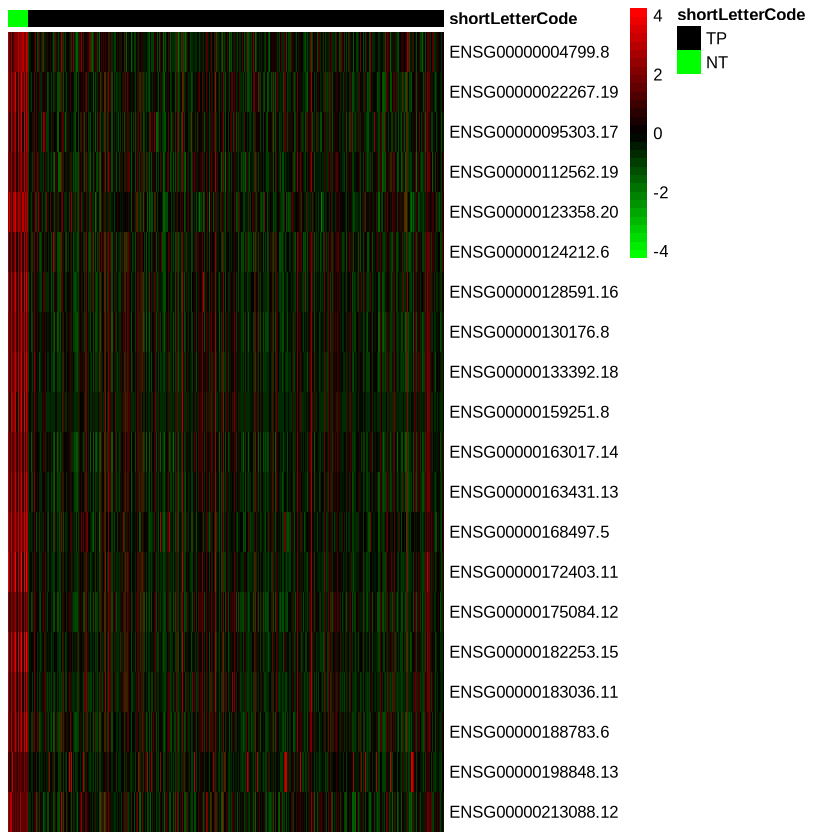

In [65]:
# Custom color schemes for annotations
annotation_colors <- list( shortLetterCode =c("TP" = "black", "NT" = "green"))

# Creating the heatmap
pheatmap(
  t(final_mat),  # Transpose data if necessary
  color = colorRampPalette(c("green", "black", "red"))(n = 30),
  scale = "row",
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  annotation_col = metadata,
  annotation_colors = annotation_colors,
  show_rownames = TRUE,
  show_colnames = FALSE,
  width = 1000,
  height = 500
)

## Volcano mRNA

### Change options because of error from labels 

In [41]:
options(ggrepel.max.overlaps = 20)

In [42]:
res<-TCGAVisualize_volcano(
    x = dataDEGs$logFC,
    y = dataDEGs$FDR,
    filename = "volcanoexp.png",
    names = rownames(dataDEGs),
    color = c("black","red","darkgreen"),
    names.size = 2,
    xlab = " Gene expression fold change (Log2)",
    legend = "State",
    title = "Volcano plot (TP vs NT)",
    width = 10,
    x.cut = 1
)

Saving file as: volcanoexp.png

Warning message:
“ggrepel: 4196 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


## PCA mRNA

Warning message:
“In prcomp.default(t(expr2), cor = TRUE) :
 extra argument ‘cor’ will be disregarded”


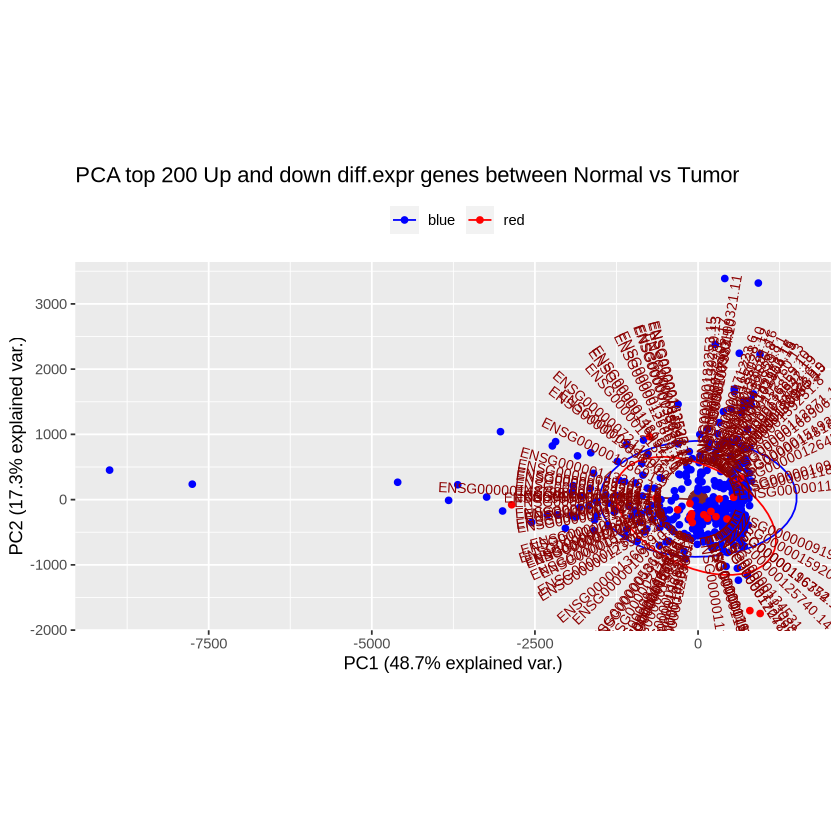

In [51]:
pca <- TCGAvisualize_PCA(
    dataFilt = data_matrix,
    dataDEGsFiltLevel = dataDEGsFiltLevel,
    ntopgenes = 200, 
    group1 = samples.primary.tumour,
    group2 =  samples.solid.tissue.normal
)

## Hist mRNA

In [52]:
# Find and print the maximum value of the matrix
max_value <- max(data_matrix)
max_value

# Flatten the matrix into a vector
mat_vector <- as.vector(data_matrix)

png(filename = "hist.png", width = 1200, height = 480,
    units = "px", pointsize = 12, bg = "white")

# Create a histogram
hist(mat_vector, main = "Histogram of Expression Values", xlab = "Values", col = "lightblue", border = "black", breaks=100)

dev.off()

[1] 319762.4


png 
  2

# miRNA


In [18]:
query.miRNA <- GDCquery(project = "TCGA-BLCA",experimental.strategy = "miRNA-Seq",data.category = "Transcriptome Profiling", 
    data.type = "miRNA Expression Quantification", access = "open")

samplesDown.miRNA <- getResults(query.miRNA,cols=c("cases"))

dataSmTP.miR <- TCGAquery_SampleTypes(barcode = samplesDown.miRNA,typesample = "TP")
dataSmNT.miR <- TCGAquery_SampleTypes(barcode = samplesDown.miRNA,typesample = "NT")

query.miRNA <- GDCquery(project = "TCGA-BLCA",experimental.strategy = "miRNA-Seq",data.category = "Transcriptome Profiling", 
    data.type = "miRNA Expression Quantification",barcode = c(dataSmTP.miR, dataSmNT.miR), access = "open")

GDCdownload(query = query.miRNA)

dataAssy.miR <- GDCprepare(query = query.miRNA)

rownames(dataAssy.miR) <- dataAssy.miR$miRNA_ID

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--------------------

ooo By access

ooo By experimental.strategy

ooo By data.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--

  |======================================================================| 100%


In [53]:
# saveRDS(dataAssy.miR, "downloaded_dataAssy_miR.rds")
# saveRDS(dataSmTP.miR, "dataSmTP._miR.rds")
# saveRDS(dataSmNT.miR, "dataSmNT_miRrds")

In [41]:
dataAssy.miR <- readRDS("downloaded_dataAssy_miR.rds")
# dataSmTP.miR <- readRDS("dataSmTP._miR.rds")
# dataSmNT.miR <- readRDS("dataSmNT_miRrds")

In [42]:
head(dataAssy.miR)

,miRNA_ID,read_count_TCGA-DK-A2I2-01A-11R-A17X-13,reads_per_million_miRNA_mapped_TCGA-DK-A2I2-01A-11R-A17X-13,cross-mapped_TCGA-DK-A2I2-01A-11R-A17X-13,read_count_TCGA-E7-A6MF-01A-12R-A32J-13,reads_per_million_miRNA_mapped_TCGA-E7-A6MF-01A-12R-A32J-13,cross-mapped_TCGA-E7-A6MF-01A-12R-A32J-13,read_count_TCGA-DK-A3IV-01A-22R-A21E-13,reads_per_million_miRNA_mapped_TCGA-DK-A3IV-01A-22R-A21E-13,cross-mapped_TCGA-DK-A3IV-01A-22R-A21E-13,⋯,cross-mapped_TCGA-K4-A54R-11A-11R-A26X-13,read_count_TCGA-GD-A2C5-11A-11R-A17X-13,reads_per_million_miRNA_mapped_TCGA-GD-A2C5-11A-11R-A17X-13,cross-mapped_TCGA-GD-A2C5-11A-11R-A17X-13,read_count_TCGA-CU-A0YN-11A-11R-A10V-13,reads_per_million_miRNA_mapped_TCGA-CU-A0YN-11A-11R-A10V-13,cross-mapped_TCGA-CU-A0YN-11A-11R-A10V-13,read_count_TCGA-BT-A20Q-11A-11R-A14X-13,reads_per_million_miRNA_mapped_TCGA-BT-A20Q-11A-11R-A14X-13,cross-mapped_TCGA-BT-A20Q-11A-11R-A14X-13
,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,⋯,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>
hsa-let-7a-1,hsa-let-7a-1,18587,4227.1177,N,44934,25109.4564,N,69295,9249.8609,N,⋯,N,102603,10270.5963,N,25562,4260.9867,N,21645,1261.2378,N
hsa-let-7a-2,hsa-let-7a-2,18617,4233.9404,N,45179,25246.3643,N,68297,9116.6426,Y,⋯,N,101773,10187.5130,Y,26018,4336.9983,Y,21638,1260.8299,Y
hsa-let-7a-3,hsa-let-7a-3,18769,4268.5087,N,45617,25491.1219,N,69483,9274.9561,N,⋯,N,102396,10249.8755,N,25961,4327.4969,N,21335,1243.1743,N
hsa-let-7b,hsa-let-7b,20740,4716.7601,N,42209,23586.7060,N,92986,12412.2601,N,⋯,N,116070,11618.6477,N,29301,4884.2489,N,21871,1274.4067,N
hsa-let-7c,hsa-let-7c,1374,312.4797,N,1908,1066.2047,N,3565,475.8749,Y,⋯,N,46472,4651.8635,Y,14276,2379.6982,Y,7916,461.2593,Y
hsa-let-7d,hsa-let-7d,3616,822.3628,N,1455,813.0649,N,5522,737.1056,N,⋯,N,4726,473.0743,N,974,162.3582,N,2266,132.0381,N


## Take columns that start with "read_count_" (for raw data) and create matrix

In [29]:
read_countData <-  colnames(dataAssy.miR)[grep("read_count_", colnames(dataAssy.miR))]

data_matrix_miR <- dataAssy.miR[,read_countData]

colnames(data_matrix_miR) <- gsub("read_count_","", colnames(data_matrix_miR))

head(data_matrix_miR)

,TCGA-DK-A2I2-01A-11R-A17X-13,TCGA-E7-A6MF-01A-12R-A32J-13,TCGA-DK-A3IV-01A-22R-A21E-13,TCGA-FD-A6TA-01A-12R-A33A-13,TCGA-FD-A62S-01A-11R-A30J-13,TCGA-BT-A20T-01A-11R-A14X-13,TCGA-UY-A78M-01A-21R-A358-13,TCGA-DK-AA6L-01A-11R-A39B-13,TCGA-FD-A5BT-01A-11R-A26X-13,TCGA-KQ-A41S-01A-12R-A33A-13,⋯,TCGA-BT-A2LB-11A-11R-A18B-13,TCGA-GC-A3WC-11A-11R-A22V-13,TCGA-BL-A13J-11A-13R-A10V-13,TCGA-CU-A0YR-11A-13R-A10V-13,TCGA-BT-A2LA-11A-11R-A18B-13,TCGA-BT-A20U-11A-11R-A14X-13,TCGA-K4-A54R-11A-11R-A26X-13,TCGA-GD-A2C5-11A-11R-A17X-13,TCGA-CU-A0YN-11A-11R-A10V-13,TCGA-BT-A20Q-11A-11R-A14X-13
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
hsa-let-7a-1,18587,44934,69295,33473,41076,38391,18145,63904,41545,41340,⋯,57605,39790,51229,29017,86514,8503,36292,102603,25562,21645
hsa-let-7a-2,18617,45179,68297,33315,41241,38219,18167,63826,41446,41514,⋯,57248,39588,51276,28944,86180,8286,35489,101773,26018,21638
hsa-let-7a-3,18769,45617,69483,33272,41651,38833,18407,63614,42140,41707,⋯,57404,39676,51136,28836,86300,8297,36240,102396,25961,21335
hsa-let-7b,20740,42209,92986,44763,37589,64017,17906,89882,81933,32866,⋯,75220,40210,45161,35267,118660,12683,51379,116070,29301,21871
hsa-let-7c,1374,1908,3565,3551,5308,4383,1166,6028,17365,6863,⋯,34630,20292,25964,18441,20147,4262,9625,46472,14276,7916
hsa-let-7d,3616,1455,5522,2536,3808,1171,1801,2460,4868,3332,⋯,4036,1968,2631,1426,4443,303,1913,4726,974,2266


In [17]:
saveRDS(data_matrix_miR,"raw_data_matrix_miR.rds")

## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [39]:
# keep first 16 characters from colnames, which are sample ids
sample_ids <- substr(colnames(data_matrix_miR), 0, 16)

# find duplicated samples in colData(dataPrep)
patient_duplicates <- sample_ids[which(duplicated(sample_ids))]

# use function duplicates_index_to_remove for every element in patient_duplicates
patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove, input_matrix = data_matrix_miR)

print("Index of duplicates with the most zeros per patient with duplicates")
patient_duplicates_to_remove

print("The names of the columns that will be removed")
colnames(data_matrix_miR)[patient_duplicates_to_remove]

TCGA-C4-A0F7-01A-11R-A25G-13 TCGA-C4-A0F7-01A-11R-A085-13 
                        1110                         1318 
TCGA-C4-A0F1-01A-11R-A25G-13 TCGA-C4-A0F1-01A-11R-A035-13 
                        1149                         1309 
TCGA-BL-A0C8-01A-11R-A10V-13 TCGA-BL-A0C8-01A-11R-A27D-13 
                        1215                         1179 
TCGA-BL-A13I-01A-11R-A27D-13 TCGA-BL-A13I-01A-11R-A13X-13 
                        1207                         1274 
TCGA-BL-A13J-01A-11R-A27D-13 TCGA-BL-A13J-01A-11R-A10V-13 
                        1141                         1172 
[1] "Index of duplicates with the most zeros per patient with duplicates"


TCGA-C4-A0F7-01A TCGA-C4-A0F1-01A TCGA-BL-A0C8-01A TCGA-BL-A13I-01A 
             132              148              130              264 
TCGA-BL-A13J-01A 
             375

[1] "The names of the columns that will be removed"


[1] "TCGA-C4-A0F7-01A-11R-A085-13" "TCGA-C4-A0F1-01A-11R-A035-13"
[3] "TCGA-BL-A0C8-01A-11R-A10V-13" "TCGA-BL-A13I-01A-11R-A13X-13"
[5] "TCGA-BL-A13J-01A-11R-A10V-13"

In [40]:
# Remove the specified-duplicated columns
data_matrix_miR <- data_matrix_miR[, -patient_duplicates_to_remove, drop = FALSE]
dim(data_matrix_miR)

[1] 1881  431

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [75]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(data_matrix_miR, 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 313

In [76]:
dim(data_matrix_miR)

[1] 1881  436

### A matrix in R can only hold one type of data, if first element is integer/double, then all the elements in this matrix are integers/doubles

In [68]:
typeof(data_matrix_miR[1,1])

[1] "integer"

## Take columns that start with "reads_per_million_miRNA" (for normalized data) and create matrix

In [43]:
read_countData <-  colnames(dataAssy.miR)[grep("reads_per_million_miRNA", colnames(dataAssy.miR))]

data_matrix_miR <- dataAssy.miR[,read_countData]

colnames(data_matrix_miR) <- gsub("reads_per_million_miRNA_mapped_","", colnames(data_matrix_miR))

head(data_matrix_miR)

,TCGA-DK-A2I2-01A-11R-A17X-13,TCGA-E7-A6MF-01A-12R-A32J-13,TCGA-DK-A3IV-01A-22R-A21E-13,TCGA-FD-A6TA-01A-12R-A33A-13,TCGA-FD-A62S-01A-11R-A30J-13,TCGA-BT-A20T-01A-11R-A14X-13,TCGA-UY-A78M-01A-21R-A358-13,TCGA-DK-AA6L-01A-11R-A39B-13,TCGA-FD-A5BT-01A-11R-A26X-13,TCGA-KQ-A41S-01A-12R-A33A-13,⋯,TCGA-BT-A2LB-11A-11R-A18B-13,TCGA-GC-A3WC-11A-11R-A22V-13,TCGA-BL-A13J-11A-13R-A10V-13,TCGA-CU-A0YR-11A-13R-A10V-13,TCGA-BT-A2LA-11A-11R-A18B-13,TCGA-BT-A20U-11A-11R-A14X-13,TCGA-K4-A54R-11A-11R-A26X-13,TCGA-GD-A2C5-11A-11R-A17X-13,TCGA-CU-A0YN-11A-11R-A10V-13,TCGA-BT-A20Q-11A-11R-A14X-13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-let-7a-1,4227.1177,25109.4564,9249.8609,5408.8206,5888.8051,11645.356,5980.6385,9529.8385,6661.8208,5619.6561,⋯,8035.1911,4950.4501,3714.0472,4619.0035,11074.0287,5780.2525,8489.8909,10270.5963,4260.9867,1261.2378
hsa-let-7a-2,4233.9404,25246.3643,9116.6426,5383.2897,5912.4601,11593.182,5987.8897,9518.2066,6645.9460,5643.3093,⋯,7985.3940,4925.3184,3717.4546,4607.3831,11031.2758,5632.7381,8302.0429,10187.5130,4336.9983,1260.8299
hsa-let-7a-3,4268.5087,25491.1219,9274.9561,5376.3415,5971.2392,11779.430,6066.9944,9486.5916,6757.2302,5669.5452,⋯,8007.1540,4936.2668,3707.3048,4590.1914,11046.6361,5640.2158,8477.7264,10249.8755,4327.4969,1243.1743
hsa-let-7b,4716.7601,23586.7060,12412.2601,7233.1442,5388.8961,19418.633,5901.8635,13403.8706,13138.1145,4467.7218,⋯,10492.2676,5002.7041,3274.1237,5613.8951,15188.8047,8621.7738,12019.2358,11618.6477,4884.2489,1274.4067
hsa-let-7c,312.4797,1066.2047,475.8749,573.7974,760.9742,1329.520,384.3166,898.9401,2784.5112,932.9390,⋯,4830.4603,2524.6176,1882.3619,2935.4876,2578.8711,2897.2641,2251.6037,4651.8635,2379.6982,461.2593
hsa-let-7d,822.3628,813.0649,737.1056,409.7861,545.9288,355.206,593.6142,366.8534,780.5932,452.9437,⋯,562.9725,244.8476,190.7447,226.9945,568.7162,205.9763,447.5135,473.0743,162.3582,132.0381


## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [44]:
# keep first 16 characters from colnames, which are sample ids
sample_ids <- substr(colnames(data_matrix_miR), 0, 16)

# find duplicated samples in colData(dataPrep)
patient_duplicates <- sample_ids[which(duplicated(sample_ids))]

# use function duplicates_index_to_remove for every element in patient_duplicates
patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove, input_matrix = data_matrix_miR)

print("Index of duplicates with the most zeros per patient with duplicates")
patient_duplicates_to_remove

print("The names of the columns that will be removed")
colnames(data_matrix_miR)[patient_duplicates_to_remove]

TCGA-C4-A0F7-01A-11R-A25G-13 TCGA-C4-A0F7-01A-11R-A085-13 
                        1110                         1318 
TCGA-C4-A0F1-01A-11R-A25G-13 TCGA-C4-A0F1-01A-11R-A035-13 
                        1149                         1309 
TCGA-BL-A0C8-01A-11R-A10V-13 TCGA-BL-A0C8-01A-11R-A27D-13 
                        1215                         1179 
TCGA-BL-A13I-01A-11R-A27D-13 TCGA-BL-A13I-01A-11R-A13X-13 
                        1207                         1274 
TCGA-BL-A13J-01A-11R-A27D-13 TCGA-BL-A13J-01A-11R-A10V-13 
                        1141                         1172 
[1] "Index of duplicates with the most zeros per patient with duplicates"


TCGA-C4-A0F7-01A TCGA-C4-A0F1-01A TCGA-BL-A0C8-01A TCGA-BL-A13I-01A 
             132              148              130              264 
TCGA-BL-A13J-01A 
             375

[1] "The names of the columns that will be removed"


[1] "TCGA-C4-A0F7-01A-11R-A085-13" "TCGA-C4-A0F1-01A-11R-A035-13"
[3] "TCGA-BL-A0C8-01A-11R-A10V-13" "TCGA-BL-A13I-01A-11R-A13X-13"
[5] "TCGA-BL-A13J-01A-11R-A10V-13"

In [45]:
# Remove the specified-duplicated columns
data_matrix_miR <- data_matrix_miR[, -patient_duplicates_to_remove, drop = FALSE]
dim(data_matrix_miR)

[1] 1881  431

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [80]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(data_matrix_miR, 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 313

### A matrix in R can only hold one type of data, if first element is integer/double, then all the elements in this matrix are integers/doubles

In [70]:
typeof(data_matrix_miR[1,1])

[1] "double"

## Max value of a matrix

In [30]:
which(data_matrix_miR == max(data_matrix_miR), arr.ind = TRUE)
colnames(data_matrix_miR)[418]
data_matrix_miR[190,418]

,row,col
hsa-mir-143,190,418


## DEA

In [58]:
# dataFilt.miR <- TCGAanalyze_Filtering(tabDF = dataAssy.miR,method = "quantile",qnt.cut =  0.25)   

dataDEGs.miR <- TCGAanalyze_DEA(mat1 = data_matrix_miR[,dataSmNT.miR],mat2 = data_matrix_miR[,dataSmTP.miR],Cond1type = "Normal",
    Cond2type = "Tumor",fdr.cut = 0.01 ,logFC.cut = 1,method = "glmLRT") 

Batch correction skipped since no factors provided

----------------------- DEA -------------------------------

o 19 samples in Cond1type Normal

o 417 samples in Cond2type Tumor

o 1881 features as miRNA or genes 

This may take some minutes...

----------------------- END DEA -------------------------------



## Changed first column to miRNA, but maybe TCGAanalyze_LevelTab is only for mRNA (FC_FDR_table_mRNA)

In [59]:
dataDEGsFiltLevel.miR <- TCGAanalyze_LevelTab(FC_FDR_table_mRNA = dataDEGs.miR,typeCond1 = "Tumor",typeCond2 = "Normal",TableCond1 = data_matrix_miR[,dataSmTP.miR],
    TableCond2 = data_matrix_miR[,dataSmNT.miR])

colnames(dataDEGsFiltLevel.miR)[1] <- "miRNA"

head(dataDEGsFiltLevel.miR)

,miRNA,logFC,FDR,Delta,Tumor,Normal
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-mir-21,hsa-mir-21,2.216279,6.710475e-26,672882.66,303609.24,65335.314
hsa-mir-182,hsa-mir-182,2.830011,1.867410e-11,73838.71,26091.32,3669.148
hsa-mir-203a,hsa-mir-203a,1.987820,3.825456e-03,65968.12,33186.16,8366.787
hsa-mir-183,hsa-mir-183,3.575300,2.108294e-14,52980.80,14818.56,1243.064
hsa-mir-200c,hsa-mir-200c,2.017406,2.092149e-06,35751.15,17721.34,4377.110
hsa-mir-205,hsa-mir-205,2.650162,1.723964e-06,28852.65,10887.13,1734.238


## PCA miRNA

Warning message:
“In prcomp.default(t(expr2), cor = TRUE) :
 extra argument ‘cor’ will be disregarded”
Warning message:
“Removed 23 rows containing missing values (`geom_text()`).”


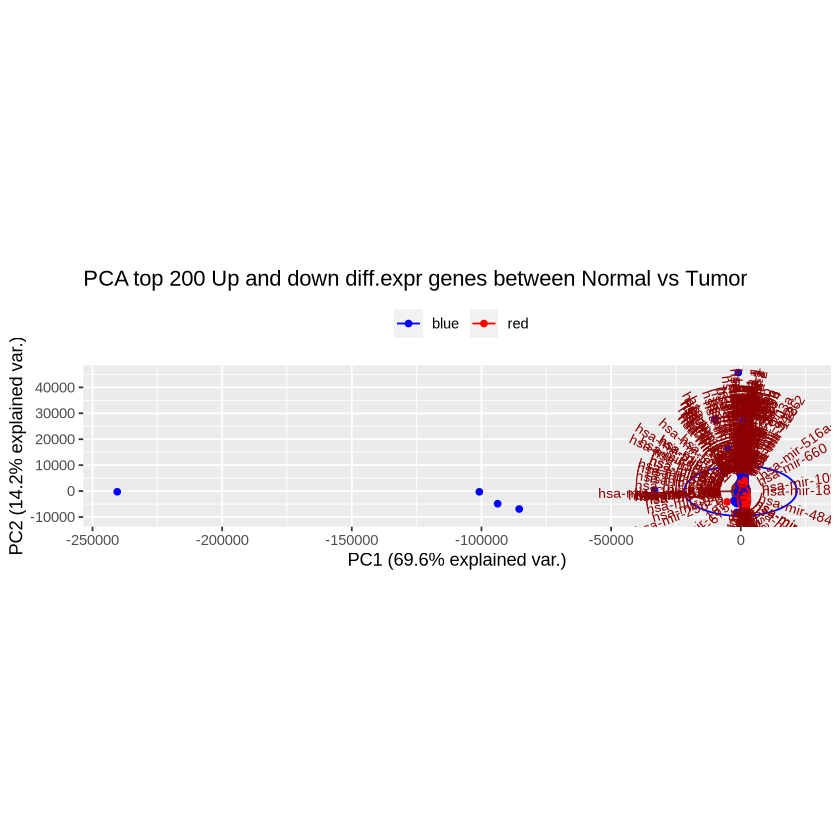

In [60]:
pca <- TCGAvisualize_PCA(
    dataFilt = data_matrix_miR,
    dataDEGsFiltLevel = dataDEGsFiltLevel.miR,
    ntopgenes = 200, 
    group1 = dataSmTP.miR,
    group2 = dataSmNT.miR
)

## Hist miRNA

In [61]:
# Assuming df is your dataframe
# You can use the unlist function to convert the dataframe to a vector
data_vector <- unlist(data_matrix_miR)

png(filename = "hist_miRNA.png", width = 1200, height = 480,
    units = "px", pointsize = 12, bg = "white")

# Create a histogram
hist(data_vector, main = "Histogram of All Columns", xlab = "Values", col = "lightblue", border = "black", breaks=100)

dev.off()

png 
  2

# Methylation


In [81]:
query_met <- GDCquery(
    project = "TCGA-BLCA", 
    data.category = "DNA Methylation", 
    data.type = "Methylation Beta Value",
    platform = "Illumina Human Methylation 450", 
    access = "open"
)

samplesDown_met <- getResults(query_met,cols=c("cases"))

# return barcodes that are TP
dataSmTP_met <- TCGAquery_SampleTypes(barcode = samplesDown_met,typesample = "TP")
# return barcodes that are NT
dataSmNT_met <- TCGAquery_SampleTypes(barcode = samplesDown_met,typesample = "NT")

query_met <- GDCquery(
    project = "TCGA-BLCA", 
    data.category = "DNA Methylation", 
    data.type = "Methylation Beta Value",
    platform = "Illumina Human Methylation 450", 
    access = "open",
    barcode = c(dataSmTP_met, dataSmNT_met)
)

GDCdownload(query = query_met)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--------------------

ooo By platform

ooo By access

ooo By data.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

---------------

Downloading: 390 MB     

Downloading: 390 MB     

Downloading: 390 MB     

Downloading: 400 MB     

Downloading: 390 MB     

Downloading: 310 MB     

In [82]:
saveRDS(query_met, "query_met.rds")

In [4]:
query_met <- readRDS("query_met.rds")

In [ ]:
data_met <- GDCprepare(query_met)
saveRDS(data_met, "downloaded_data_met.rds")
saveRDS(dataSmTP_met,"dataSmTP_met.rds")
saveRDS(dataSmNT_met,"dataSmNT_met.rds")

In [14]:
data_met <- readRDS("downloaded_data_met.rds")
# dataSmTP_met <- readRDS("dataSmTP_met.rds")
# dataSmNT_met <- readRDS("dataSmNT_met.rds")
# data_met

In [15]:
dim(assay(data_met))
head(assay(data_met))

[1] 485577    439

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
cg13869341,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg14008030,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg12045430,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg20826792,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg00381604,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg20253340,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [16]:
meth_matrix <- assay(data_met)
head(meth_matrix)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
cg13869341,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg14008030,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg12045430,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg20826792,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg00381604,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg20253340,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Check for duplicates

In [12]:
colData(data_met)$sample[which(duplicated(colData(data_met)$sample))]

[1] "TCGA-BL-A13I-01A" "TCGA-BL-A0C8-01A" "TCGA-BL-A13J-01A"

In [524]:
which(colData(data_met)$sample %in% "TCGA-BL-A13J-01A")

[1] 369 398

In [525]:
i=1

In [764]:
i
colnames(colData(data_met))[i]
unique(colData(data_met)[c(369,398),i])
i=i+1

[1] 239

[1] NA

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'unique': subscript contains out-of-bounds indices


In [765]:
colData(data_met)[c(369,398),"treatments"]

,days_to_treatment_end,days_to_treatment_start,treatment_id,submitter_id,treatment_type,regimen_or_line_of_therapy,treatment_effect,therapeutic_agents,treatment_or_therapy,created_datetime,initial_disease_status,treatment_intent_type,treatment_anatomic_site,updated_datetime,treatment_outcome,state
,<lgl>,<lgl>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>
1,NA,NA,04e5320c-e9af-52f4-af45-77a50901166e,TCGA-BL-A13J_treatment_1,"Pharmaceutical Therapy, NOS",NA,NA,NA,no,2019-04-28T09:52:57.016776-05:00,NA,NA,NA,2019-07-31T16:49:37.529457-05:00,NA,released
2,NA,NA,691d6cde-1889-5398-be89-5d0b9c88851b,TCGA-BL-A13J_treatment,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,2019-07-31T16:49:37.529457-05:00,NA,released
,days_to_treatment_end,days_to_treatment_start,treatment_id,submitter_id,treatment_type,regimen_or_line_of_therapy,treatment_effect,therapeutic_agents,treatment_or_therapy,created_datetime,initial_disease_status,treatment_intent_type,treatment_anatomic_site,updated_datetime,treatment_outcome,state
,<lgl>,<lgl>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>
1,NA,NA,04e5320c-e9af-52f4-af45-77a50901166e,TCGA-BL-A13J_treatment_1,"Pharmaceutical Therapy, NOS",NA,NA,NA,no,2019-04-28T09:52:57.016776-05:00,NA,NA,NA,2019-07-31T16:49:37.529457-05:00,NA,released
2,NA,NA,691d6cde-1889-5398-be89-5d0b9c88851b,TCGA-BL-A13J_treatment,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,2019-07-31T16:49:37.529457-05:00,NA,released


In [766]:
colData(data_met)[c(369,398),"primary_site"]

[[1]]
[1] "Bladder"

[[2]]
[1] "Bladder"

In [767]:
colData(data_met)[c(369,398),"disease_type"]

[[1]]
[1] "Squamous Cell Neoplasms"                    
[2] "Adenomas and Adenocarcinomas"               
[3] "Epithelial Neoplasms, NOS"                  
[4] "Transitional Cell Papillomas and Carcinomas"

[[2]]
[1] "Squamous Cell Neoplasms"                    
[2] "Adenomas and Adenocarcinomas"               
[3] "Epithelial Neoplasms, NOS"                  
[4] "Transitional Cell Papillomas and Carcinomas"

In [276]:
data <- colData(data_met)
data$treatments <- as.character(data$treatments)
data$primary_site <- as.character(data$primary_site)
data$disease_type <- as.character(data$disease_type)

In [768]:
# Assuming your data frame is named 'df' and you want to compare row 1 and row 2
row1 <- data[369, 2:238]
row2 <- data[398, 2:238]

identical(as.list(row1), as.list(row2))


[1] TRUE

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [83]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(assay(data_met), 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 64220

### A matrix in R can only hold one type of data, if first element is integer/double, then all the elements in this matrix are integers/doubles

In [73]:
typeof(assay(data_met)[1,1])

[1] "double"

## Remove the rows that have at least one NA

In [84]:
# na.omit
data_met <- data_met[rowSums(is.na(assay(data_met))) == 0,]
head(assay(data_met))

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
cg16619049,0.3756185,0.03666365,0.4997181,0.2023811,0.3520077,0.3108895,0.2993181,0.2349854,0.2127136,0.4577936,⋯,0.4038090,0.4894903,0.4352221,0.4644328,0.4522823,0.3883846,0.3454956,0.4294653,0.3881193,0.3837940
cg18147296,0.6587823,0.75214447,0.7269647,0.6757211,0.6300320,0.5469870,0.8340163,0.6970405,0.6927025,0.7092280,⋯,0.6744512,0.6361787,0.6522986,0.6125903,0.6445321,0.5559067,0.5434577,0.6293830,0.5565833,0.6541837
cg13938959,0.4730780,0.91998643,0.4880943,0.4145957,0.6354954,0.3862603,0.4176617,0.5102106,0.3306258,0.6812871,⋯,0.7340995,0.7816124,0.7907097,0.7685573,0.8704710,0.7944413,0.8729773,0.5421802,0.8290652,0.8006693
cg12445832,0.2910751,0.88852353,0.3300772,0.2093543,0.3620125,0.2583255,0.2360047,0.2946073,0.2390897,0.4281056,⋯,0.5190293,0.5062436,0.6467032,0.5405029,0.7525516,0.5865062,0.6265222,0.4008233,0.6150903,0.6264947
cg23999112,0.5600379,0.89377422,0.4990788,0.5443186,0.8551309,0.4092382,0.4892752,0.4753013,0.3533445,0.6960211,⋯,0.8633101,0.8123911,0.8906572,0.8954997,0.9194234,0.9157894,0.9187857,0.6748022,0.9166921,0.8302839
cg11527153,0.7307246,0.52660896,0.7823555,0.5567775,0.5710294,0.4140516,0.6276143,0.6893751,0.6281392,0.8491099,⋯,0.8524084,0.7904111,0.8995841,0.8998211,0.8944471,0.9118951,0.8879874,0.6809255,0.8821675,0.8974090


In [85]:
meth_matrix <- assay(data_met)

## DMC (p.cut = 10^-5 from tutorial, 0.01 and 0.2 are defaults)

In [97]:
data <- TCGAanalyze_DMC(
    data = data_met, 
    groupCol = "shortLetterCode",
    group1 = "TP",
    group2 = "NT",
    p.cut = 10^-5,
    diffmean.cut = 0.25,
    legend = "State",
    plot.filename = "TP_vs_NT_volcanoMeth.pdf"
)

saveRDS(data,"dmc_data_new.rds")

Group1:TP

Group2:NT

Calculating the p-values of each probe...



|====================================================|100%                      gggCompleted after 2 h 


Saving volcano plot as: TP_vs_NT_volcanoMeth.pdf

Saving file as: TP_vs_NT_volcanoMeth.pdf

Saving the results also in a csv file: ./DMR_results_shortLetterCode_TP_NT_pcut_1e-05_meancut_0.25.csv



In [ ]:
data_dmc <- readRDS("dmc_data_new.rds")

## Mean Methylation

In [92]:
TCGAvisualize_meanMethylation(data = data_met,groupCol = "shortLetterCode")

==================== DATA Summary ====================



  groups      Mean    Median       Max       Min
1     NT 0.4542998 0.4550942 0.4641738 0.4359059
2     TP 0.4231514 0.4297572 0.5149086 0.3101189


==================== END DATA Summary ====================

==================== T test results ====================



             TP           NT
TP           NA 6.962675e-29
NT 6.962675e-29           NA


==================== END T test results ====================



  [1] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [16] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [31] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [46] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [61] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [76] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [91] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[106] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[121] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[136] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[151] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[166] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[181] "TP" "TP" "TP" "TP" "T

Plot saved in:  /home/thlamp/tcga/bladder_results/groupMeanMet.pdf



## Hist Meth

In [15]:
# Find the maximum value of the matrix
max_value <- max(meth_matrix)

# Print the result
print(max_value)

# Flatten the matrix into a vector
mat_vector <- as.vector(meth_matrix)

png(filename = "hist_meth.png", width = 1200, height = 480,
    units = "px", pointsize = 12, bg = "white")

# Create a histogram
hist(mat_vector, main = "Histogram of Methylation Values", xlab = "Values", col = "lightblue", border = "black", breaks=100)

dev.off()

[1] 0.9951354


png 
  2

In [36]:
head(dataDEGs)

,logFC,logCPM,LR,PValue,FDR,gene_name,gene_type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000000003.15,-0.1527518,6.934034,1.183089,0.2767280419,0.90654878,NA,NA
ENSG00000000005.6,0.9458677,5.075900,5.652517,0.0174303388,0.19878254,NA,NA
ENSG00000000460.17,-0.7218856,6.145499,9.701813,0.0018408635,0.03681727,NA,NA
ENSG00000000938.13,0.1911563,6.273903,1.135949,0.2865099859,0.91587146,NA,NA
ENSG00000000971.16,0.4955941,6.587191,11.865264,0.0005719067,0.01462557,NA,NA
ENSG00000001036.14,-0.1503554,6.905229,1.118471,0.2902478855,0.91863067,NA,NA


## Add gene name and gene type at dataDEGs_new (for mRNA)

In [14]:
dataDEGs_new <- dataDEGs
dataDEGs_new$gene_name <- apply(as.matrix(rownames(dataDEGs_new)),1, function (x){
  row_data$gene_name[which(row_data$gene_id %in% x)]})
dataDEGs_new$gene_type <- apply(as.matrix(rownames(dataDEGs_new)),1, function (x){
  row_data$gene_type[which(row_data$gene_id %in% x)]})
head(dataDEGs_new)

ERROR: Error in eval(expr, envir, enclos): object 'data_dmc' not found


## data_dmc is object from readRDS for DMC data, add new column with probe IDS

In [ ]:
data_dmc_new <- data_dmc
data_dmc_new$probeID <- ""
dmc_rownames <- rownames(data_dmc_new)
data_dmc_new$probeID <-dmc_rownames

In [39]:
head(data_dmc_new)

,mean.TP,mean.NT,mean.TP.minus.mean.NT,p.value.TP.NT,p.value.adj.TP.NT,status,probeID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cg16619049,0.3050122,0.4284076,-0.12339541,5.958731e-05,2.176044e-04,Not Significant,cg16619049
cg18147296,0.6752837,0.6369843,0.03829937,1.162804e-02,2.238072e-02,Not Significant,cg18147296
cg13938959,0.5108953,0.7744803,-0.26358494,3.742539e-09,4.562984e-08,Hypomethylated in TP,cg13938959
cg12445832,0.3073540,0.5808143,-0.27346027,9.698621e-11,2.590277e-09,Hypomethylated in TP,cg12445832
cg23999112,0.5795147,0.8530734,-0.27355870,4.630471e-09,5.452269e-08,Hypomethylated in TP,cg23999112
cg11527153,0.6718636,0.8591173,-0.18725372,1.368352e-07,9.916008e-07,Not Significant,cg11527153


## Change mean.TP.minus.mean.NT to diffmean.TP.NT to avoid error in TCGAvisualize_starburst

In [40]:
colnames(data_dmc_new)[3] ="diffmean.TP.NT"

## Starburst with data_dmc_new and dataDEGs_new

In [53]:
starburst <- TCGAvisualize_starburst(
    met = data_dmc_new, 
    exp = dataDEGs_new,
    genome = "hg38",
    group1 = "TP",
    group2 = "NT",
    filename = "starburst(logFC_1).png",
    met.platform = "Illumina Human Methylation 450",
    met.p.cut = 10^-5,
    exp.p.cut = 10^-5,
    diffmean.cut = 0.25,
    logFC.cut = 1,
    names = FALSE, 
    height = 10,
    width = 15,
    dpi = 300
)

o Fetching auxiliary information

oo Fetching probes genomic information

Accessing DNAm annotation from sesame package for: hg38 - HM450

see ?sesameData and browseVignettes('sesameData') for documentation

loading from cache

o Mapping results information

o Plotting figure

Saving figure as starburst(logFC_1).png

o Saving results

oo Saving significant results as: starburst_results.csv

oo It contains pair with changes both in the expression level of the nearest gene and  in the DNA methylation level



## Download hg38 manifest by sesame package

In [5]:
tsv_path <- sesameAnno_download("HM450.hg38.manifest.gencode.v36.tsv.gz")
df <- sesameAnno_readManifestTSV(tsv_path)

Warning message:
“The following named parsers don't match the column names: address_A, address_B, target, nextBase, channel, Probe_ID, mapFlag_A, mapChrm_A, mapPos_A, mapQ_A, mapCigar_A, AlleleA_ProbeSeq, mapNM_A, mapAS_A, mapYD_A, mapFlag_B, mapChrm_B, mapPos_B, mapQ_B, mapCigar_B, AlleleB_ProbeSeq, mapNM_B, mapAS_B, mapYD_B, type”


In [8]:
saveRDS(df,"HM450.hg38.manifest.v36.rds")

In [6]:
df <- readRDS("HM450.hg38.manifest.v36.rds")

In [6]:
dim(df)
head(df)

[1] 485577     12

CpG_chrm,CpG_beg,CpG_end,probe_strand,probeID,genesUniq,geneNames,transcriptTypes,transcriptIDs,distToTSS,CGI,CGIposition
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,15864,15866,-,cg13869341,WASH7P,WASH7P,unprocessed_pseudogene,ENST00000488147.1,13706,NA,NA
chr1,18826,18828,-,cg14008030,MIR6859-1;WASH7P,MIR6859-1;WASH7P,miRNA;unprocessed_pseudogene,ENST00000619216.1;ENST00000488147.1,-1390;10744,NA,NA
chr1,29406,29408,-,cg12045430,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1,-959;-860;-147;164,CGI:chr1:28735-29737,Island
chr1,29424,29426,-,cg20826792,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1,-941;-842;-129;146,CGI:chr1:28735-29737,Island
chr1,29434,29436,-,cg00381604,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1,-931;-832;-119;136,CGI:chr1:28735-29737,Island
chr1,68848,68850,-,cg20253340,OR4F5,OR4F5;OR4F5,protein_coding;protein_coding,ENST00000335137.4;ENST00000641515.2,-206;3430,NA,NA


### Keep only the columns that I need

In [7]:
mapping_data <- df[c("probeID","transcriptIDs")]
head(mapping_data)

probeID,transcriptIDs
<chr>,<chr>
cg13869341,ENST00000488147.1
cg14008030,ENST00000619216.1;ENST00000488147.1
cg12045430,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1
cg20826792,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1
cg00381604,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1
cg20253340,ENST00000335137.4;ENST00000641515.2


### Retain only probe IDs from the matrix after removing NAs

In [17]:
selected_probe_ids <- rownames(meth_matrix)
mapping_data <- mapping_data[which(mapping_data$probeID %in% selected_probe_ids),]
dim(mapping_data)

[1] 485577      2

### Separate transcriptIDs by ; into different row per id

In [18]:
library(tidyr)
mapping_data <- separate_rows(mapping_data, transcriptIDs, sep=";")
dim(mapping_data)
head(mapping_data,10)


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand




[1] 2771500       2

probeID,transcriptIDs
<chr>,<chr>
cg13869341,ENST00000488147.1
cg14008030,ENST00000619216.1
cg14008030,ENST00000488147.1
cg12045430,ENST00000607096.1
cg12045430,ENST00000469289.1
cg12045430,ENST00000473358.1
cg12045430,ENST00000488147.1
cg20826792,ENST00000607096.1
cg20826792,ENST00000469289.1


### NAs per column

In [19]:
colSums(is.na(mapping_data))

probeID transcriptIDs 
            0         61891

### Remove probeIDs that don't match with transcriptIDs

In [20]:
mapping_data <- mapping_data[complete.cases(mapping_data),]
dim(mapping_data)

[1] 2709609       2

### Create column with transcriptIDs_without_version

In [ ]:
# mapping_data$transcriptIDs_without_version <-gsub("\\.[0-9]*", "", mapping_data$transcriptIDs)
# head(mapping_data)

### Check values in transcriptIDs_without_version

In [14]:
# test <- grep("*\\..",mapping_data$transcriptIDs)

In [21]:
head(mapping_data)

probeID,transcriptIDs
<chr>,<chr>
cg13869341,ENST00000488147.1
cg14008030,ENST00000619216.1
cg14008030,ENST00000488147.1
cg12045430,ENST00000607096.1
cg12045430,ENST00000469289.1
cg12045430,ENST00000473358.1


### Biomart transcriptIDs to ensemblIDs

In [22]:
library(biomaRt)

In [23]:
ensembl <- useEnsembl(biomart = 'genes',dataset = "hsapiens_gene_ensembl",version = 102)

### Search for unique transcriptIDs to avoid repetitions of same transcriptIDs

In [24]:
# check number of unique transcriptIDs to be sure there are all in bm_results with ensembl_gene_id
length(unique(mapping_data$transcriptIDs))

[1] 185976

In [25]:
searchAttributes(mart = ensembl, pattern = "transcript_id")

,name,description,page
,<chr>,<chr>,<chr>
3,ensembl_transcript_id,Transcript stable ID,feature_page
4,ensembl_transcript_id_version,Transcript stable ID version,feature_page
203,ensembl_transcript_id,Transcript stable ID,structure
204,ensembl_transcript_id_version,Transcript stable ID version,structure
243,ensembl_transcript_id,Transcript stable ID,homologs
244,ensembl_transcript_id_version,Transcript stable ID version,homologs
2922,ensembl_transcript_id,Transcript stable ID,snp
2923,ensembl_transcript_id_version,Transcript stable ID version,snp
2966,ensembl_transcript_id,Transcript stable ID,snp_somatic


In [26]:
# transcript_ids <- unique(mapping_data$transcriptIDs_without_version)
transcript_ids <- unique(mapping_data$transcriptIDs)

# bm_results <- getBM(attributes = c('ensembl_gene_id', 'ensembl_transcript_id'),
#       filters = 'ensembl_transcript_id',
#       values = transcript_ids, 
#       mart = ensembl)
bm_results <- getBM(attributes = c('ensembl_gene_id', 'ensembl_transcript_id_version'),
      filters = 'ensembl_transcript_id_version',
      values = transcript_ids, 
      mart = ensembl)


Batch submitting query [>------------------------------]   3% eta: 39s

Batch submitting query [=>-----------------------------]   5% eta: 36s

Batch submitting query [=>-----------------------------]   8% eta: 34s

Batch submitting query [==>----------------------------]  11% eta: 33s

Batch submitting query [===>---------------------------]  13% eta: 31s

Batch submitting query [====>--------------------------]  16% eta: 30s

Batch submitting query [=====>-------------------------]  18% eta: 29s

Batch submitting query [======>------------------------]  21% eta: 28s

Batch submitting query [======>------------------------]  24% eta: 27s

Batch submitting query [=======>-----------------------]  26% eta: 26s

Batch submitting query [========>----------------------]  29% eta: 25s

Batch submitting query [=========>---------------------]  32% eta: 24s

Batch submitting query [==========>--------------------]  34% eta: 23s

Batch submitting query [==========>--------------------]  37% e

In [27]:
dim(bm_results)

[1] 185976      2

In [28]:
head(bm_results)

,ensembl_gene_id,ensembl_transcript_id_version
,<chr>,<chr>
1,ENSG00000227232,ENST00000488147.1
2,ENSG00000278267,ENST00000619216.1
3,ENSG00000243485,ENST00000473358.1
4,ENSG00000243485,ENST00000469289.1
5,ENSG00000284332,ENST00000607096.1
6,ENSG00000186092,ENST00000641515.2


In [29]:
head(mapping_data)

probeID,transcriptIDs
<chr>,<chr>
cg13869341,ENST00000488147.1
cg14008030,ENST00000619216.1
cg14008030,ENST00000488147.1
cg12045430,ENST00000607096.1
cg12045430,ENST00000469289.1
cg12045430,ENST00000473358.1


### Match ensembl_gene_id with the data from mapping_data by ensembl_transcript_id

In [30]:
# mapping_data$ensembl_ids <- apply(as.matrix(mapping_data$transcriptIDs_without_version),1, function (x){bm_results$ensembl_gene_id[which(bm_results$ensembl_transcript_id %in% x)]})
# head(mapping_data)
mapping_data$ensembl_ids <- apply(as.matrix(mapping_data$transcriptIDs),1, function (x){bm_results$ensembl_gene_id[which(bm_results$ensembl_transcript_id_version %in% x)]})
head(mapping_data)

probeID,transcriptIDs,ensembl_ids
<chr>,<chr>,<chr>
cg13869341,ENST00000488147.1,ENSG00000227232
cg14008030,ENST00000619216.1,ENSG00000278267
cg14008030,ENST00000488147.1,ENSG00000227232
cg12045430,ENST00000607096.1,ENSG00000284332
cg12045430,ENST00000469289.1,ENSG00000243485
cg12045430,ENST00000473358.1,ENSG00000243485


In [32]:
saveRDS(mapping_data,"mapping_data_102_with_na_features.rds")

In [36]:
mapping_data <- readRDS("mapping_data_102.rds")
head(mapping_data)

probeID,transcriptIDs,ensembl_ids
<chr>,<chr>,<chr>
cg16619049,ENST00000427857.1,ENSG00000230368
cg16619049,ENST00000432963.1,ENSG00000230368
cg16619049,ENST00000446136.1,ENSG00000230368
cg18147296,ENST00000635557.1,ENSG00000283040
cg18147296,ENST00000427857.1,ENSG00000230368
cg18147296,ENST00000446136.1,ENSG00000230368


### Keep only probeID and ensembl_ids with unique pairs of probeID and ensembl_ids

In [33]:
mapping_data <- mapping_data[c("probeID","ensembl_ids")]
dim(mapping_data)
mapping_data <- mapping_data[!duplicated(mapping_data[,c('probeID','ensembl_ids')]),]
dim(mapping_data)

[1] 2709609       2

[1] 583278      2

In [34]:
head(mapping_data)

probeID,ensembl_ids
<chr>,<chr>
cg13869341,ENSG00000227232
cg14008030,ENSG00000278267
cg14008030,ENSG00000227232
cg12045430,ENSG00000284332
cg12045430,ENSG00000243485
cg12045430,ENSG00000227232


### Check results from matching

In [10]:
which(duplicated(mapping_data$probeID))

[1]      3     12     14     16     18     20     22     24     26     27
   [11]     29     30     32     33     35     36     98    117    119    121
   [21]    123    136    138    140    142    183    185    187    189    191
   [31]    193    195    197    199    201    203    205    207    209    226
   [41]    228    238    240    242    244    246    248    250    252    325
   [51]    327    329    331    333    335    346    348    350    352    354
   [61]    356    451    453    455    457    460    462    464    466    467
   [71]    469    470    472    474    476    478    480    482    487    489
   [81]    491    493    495    497    499    501    503    505    507    509
   [91]    511    513    515    517    519    521    523    525    527    529
  [101]    531    533    603    605    607    609    611    613    615    665
  [111]    667    669    671    673    703    705    722    724    726    728
  [121]    730    732    734    736    738    740    742    744    746    748
  [131]    750    752    754    756    758    760    762    765    767    769
  [141]    771    773    775    777    779    781    783    787    789    791
  [151]    793    795    797    799    801    841    843    845    905    907
  [161]    909    911    913    915    917    919    921    923    925    927
  [171]    929    933    935    937    939    941    944    946    948    950
  [181]    953    955    957    959    961    963    965    977    979    981
  [191]    983    985    987    989    991    993    995    997   1082   1084
  [201]   1086   1123   1125   1127   1129   1131   1133   1135   1137   1139
  [211]   1141   1144   1146   1148   1150   1152   1154   1157   1159   1161
  [221]   1163   1165   1167   1169   1171   1173   1175   1177   1179   1181
  [231]   1183   1185   1187   1223   1225   1227   1229   1231   1241   1243
  [241]   1245   1247   1249   1251   1317   1319   1321   1323   1325   1327
  [251]   1329   1331   1333   1335   1337   1493   1495   1497   1499   1501
  [261]   1503   1505   1507   1509   1511   1662   1664   1731   1733   1735
  [271]   1736   1738   1739   1741   1742   1794   1796   1798   1800   1802
  [281]   1950   1952   1954   1956   1958   1960   1965   1967   1969   1971
  [291]   1973   1975   2012   2014   2016   2018   2020   2022   2024   2026
  [301]   2060   2062   2064   2066   2068   2070   2072   2074   2076   2078
  [311]   2080   2082   2084   2086   2088   2090   2111   2113   2115   2117
  [321]   2119   2121   2123   2243   2245   2247   2248   2250   2251   2253
  [331]   2254   2256   2257   2259   2260   2340   2342   2344   2346   2348
  [341]   2350   2352   2354   2356   2358   2360   2362   2413   2415   2448
  [351]   2450   2452   2454   2456   2458   2460   2491   2493   2531   2533
  [361]   2535   2537   2539   2541   2543   2545   2547   2549   2551   2553
  [371]   2555   2557   2559   2561   2651   2653   2655   2657   2659   2772
  [381]   2774   2776   2778   2780   2782   2784   2786   2788   2935   2937
  [391]   2943   2945   2947   2949   2951   2953   2955   2957   2959   2961
  [401]   2963   2965   2967   2969   2971   2973   3015   3017   3019   3021
  [411]   3248   3250   3252   3254   3256   3258   3305   3307   3309   3311
  [421]   3313   3315   3317   3319   3321   3323   3325   3327   3394   3396
  [431]   3398   3400   3402   3404   3406   3408   3410   3412   3414   3416
  [441]   3418   3420   3422   3424   3426   3428   3430   3432   3434   3436
  [451]   3438   3440   3442   3446   3448   3450   3452   3454   3456   3458
  [461]   3541   3545   3547   3549   3551   3553   3555   3557   3559   3561
  [471]   3563   3565   3567   3569   3571   3584   3604   3606   3608   3610
  [481]   3656   3658   3660   3662   3664   3666   3668   3670   3672   3674
  [491]   3676   3678   3680   3682   3684   3686   3688   3690   3692   3694
  [501]   3716   3718   3720   3722   3724   3726   3728   3730   3732   3734
  [511]   3763   3765   38

In [15]:
mapping_data[which(mapping_data$probeID %in% mapping_data$probeID[413070]),]

probeID,ensembl_ids
<chr>,<chr>
cg12727431,ENSG00000089820
cg12727431,ENSG00000102030
cg12727431,ENSG00000102032


### Create an empty dataframe to match mapping_data with values from meth_matrix

In [35]:
meth_df <- data.frame(matrix(NA, nrow = nrow(mapping_data), ncol = ncol(meth_matrix)+ncol(mapping_data)))
dim(meth_df)

[1] 583278    441

### Set colnames and insert probeID and ensembl_ids

In [36]:
colnames(meth_df)[1:2] <- c("probeID", "ensembl_ids") 
meth_df$probeID <- mapping_data$probeID
meth_df$ensembl_ids <- mapping_data$ensembl_ids
colnames(meth_df)[3:ncol(meth_df)] <- colnames(meth_matrix)
head(meth_df)

,probeID,ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,cg13869341,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,cg14008030,ENSG00000278267,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,cg14008030,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,cg12045430,ENSG00000284332,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,cg12045430,ENSG00000243485,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,cg12045430,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Insert values to meth_df from meth_matrix matched by probeID

In [37]:
transfer_values <- function(df, mat) {
  matching_rows <- match(df$probeID, rownames(mat))
  df[, 3:ncol(df)] <- mat[matching_rows, ]
  return(df)
}

meth_df_updated <- transfer_values(meth_df, meth_matrix)

In [40]:
head(meth_df_updated,100)

,probeID,ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cg13869341,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,cg14008030,ENSG00000278267,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,cg14008030,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,cg12045430,ENSG00000284332,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,cg12045430,ENSG00000243485,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,cg12045430,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,cg20826792,ENSG00000284332,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,cg20826792,ENSG00000243485,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,cg20826792,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [44]:
saveRDS(meth_df_updated,"meth_df_updated_with_na.rds")

In [6]:
meth_df_updated <- readRDS("meth_df_updated.rds")

## Check results from id mapping

In [7]:
head(meth_df_updated,2)

,probeID,ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cg16619049,ENSG00000230368,0.3756185,0.03666365,0.4997181,0.2023811,0.3520077,0.3108895,0.2993181,0.2349854,⋯,0.4038090,0.4894903,0.4352221,0.4644328,0.4522823,0.3883846,0.3454956,0.4294653,0.3881193,0.3837940
2,cg18147296,ENSG00000283040,0.6587823,0.75214447,0.7269647,0.6757211,0.6300320,0.5469870,0.8340163,0.6970405,⋯,0.6744512,0.6361787,0.6522986,0.6125903,0.6445321,0.5559067,0.5434577,0.6293830,0.5565833,0.6541837


In [8]:
head(meth_matrix,2)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
cg16619049,0.3756185,0.03666365,0.4997181,0.2023811,0.3520077,0.3108895,0.2993181,0.2349854,0.2127136,0.4577936,⋯,0.4038090,0.4894903,0.4352221,0.4644328,0.4522823,0.3883846,0.3454956,0.4294653,0.3881193,0.3837940
cg18147296,0.6587823,0.75214447,0.7269647,0.6757211,0.6300320,0.5469870,0.8340163,0.6970405,0.6927025,0.7092280,⋯,0.6744512,0.6361787,0.6522986,0.6125903,0.6445321,0.5559067,0.5434577,0.6293830,0.5565833,0.6541837


In [24]:
# convert df to matrix without two first columns
meth_mat_updated <- as.matrix(meth_df_updated[-c(1,2)])

rownames(meth_mat_updated) <- meth_df_updated$probeID

colnames(meth_mat_updated) <- colnames(meth_df_updated)[3:ncol(meth_df_updated)]

# keep unique rownames, if the one row is ok then the duplicate will be the same
check_meth_mat_updated <- meth_mat_updated[!duplicated(rownames(meth_mat_updated)), ]

# Identify common row names
common_row_names <- intersect(rownames(check_meth_mat_updated), rownames(meth_matrix))

# Check if values for common row names are identical
values_identical <- identical(check_meth_mat_updated[common_row_names, ], meth_matrix[common_row_names, ])

# Print the results
if (values_identical) {
  print("The values for the common row names are identical")
} else {
  print("The values for the common row names are not identical")
}

[1] "The values for the common row names are identical"


### Calculate mean value per column for common ensembl ids

In [49]:
meth_df_updated <- meth_df_updated[,2:length(colnames(meth_df_updated))]
head(meth_df_updated)

,ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,ENSG00000278267,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,ENSG00000284332,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,ENSG00000243485,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [51]:
length(grep("^TCGA",colnames(meth_df_updated)))

[1] 439

In [52]:
meth_df_updated <- meth_df_updated %>% group_by(ensembl_ids) %>% summarise(across(starts_with("TCGA"), ~mean(., na.rm = TRUE)))
dim(meth_df_updated)

[1] 37930   440

In [53]:
# meth_df_updated <- aggregate(meth_df_updated[3:ncol(meth_df_updated)], by=list(meth_df_updated$ensembl_ids), FUN=mean)
head(meth_df_updated)

ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,0.2387135,0.1505393,0.2540724,0.2260951,0.1840992,0.2290696,0.2191703,0.1775396,0.3547583,⋯,0.2748137,0.3906787,0.3747581,0.3083741,0.4227088,0.4090733,0.2547194,0.3605443,0.3146270,0.2483492
ENSG00000000005,0.6058278,0.7249236,0.5613239,0.4849353,0.8291706,0.7311190,0.9230132,0.6664457,0.4779466,⋯,0.8818483,0.7182355,0.7884270,0.8820460,0.8282769,0.7486529,0.8910061,0.7565295,0.9050790,0.9114697
ENSG00000000419,0.1178325,0.1234904,0.1074870,0.1131896,0.1210688,0.1209866,0.1081228,0.1165495,0.1198469,⋯,0.1283536,0.1279853,0.1322744,0.1328414,0.1118885,0.1289726,0.1308155,0.1161732,0.1299091,0.1082305
ENSG00000000457,0.2670827,0.2168660,0.2770998,0.2431043,0.2516276,0.2287701,0.2518552,0.2284875,0.2557735,⋯,0.2772068,0.2743403,0.2659583,0.2732396,0.2737861,0.2705068,0.2681463,0.2741836,0.2584690,0.2666568
ENSG00000000460,0.4436307,0.3737125,0.4417753,0.3872603,0.3896061,0.3454119,0.4138059,0.2615974,0.3971209,⋯,0.4519261,0.3996746,0.4449273,0.4474967,0.4534179,0.4513251,0.4400299,0.4234064,0.4144037,0.4409280
ENSG00000000938,0.5438053,0.4496814,0.5568034,0.6666494,0.5146676,0.4753789,0.5400387,0.5367315,0.5435034,⋯,0.5679367,0.5774811,0.5839556,0.5459100,0.6185687,0.5658374,0.5650642,0.5350111,0.5637159,0.5888963


### Convert df with mean values per gene to matrix

In [57]:
meth_mat_mean <- as.matrix(meth_df_updated[, 2:ncol(meth_df_updated)])

rownames(meth_mat_mean) <- meth_df_updated$ensembl_ids

head(meth_mat_mean)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
ENSG00000000003,0.2387135,0.1505393,0.2540724,0.2260951,0.1840992,0.2290696,0.2191703,0.1775396,0.3547583,0.2720790,⋯,0.2748137,0.3906787,0.3747581,0.3083741,0.4227088,0.4090733,0.2547194,0.3605443,0.3146270,0.2483492
ENSG00000000005,0.6058278,0.7249236,0.5613239,0.4849353,0.8291706,0.7311190,0.9230132,0.6664457,0.4779466,0.6910677,⋯,0.8818483,0.7182355,0.7884270,0.8820460,0.8282769,0.7486529,0.8910061,0.7565295,0.9050790,0.9114697
ENSG00000000419,0.1178325,0.1234904,0.1074870,0.1131896,0.1210688,0.1209866,0.1081228,0.1165495,0.1198469,0.1083114,⋯,0.1283536,0.1279853,0.1322744,0.1328414,0.1118885,0.1289726,0.1308155,0.1161732,0.1299091,0.1082305
ENSG00000000457,0.2670827,0.2168660,0.2770998,0.2431043,0.2516276,0.2287701,0.2518552,0.2284875,0.2557735,0.2775308,⋯,0.2772068,0.2743403,0.2659583,0.2732396,0.2737861,0.2705068,0.2681463,0.2741836,0.2584690,0.2666568
ENSG00000000460,0.4436307,0.3737125,0.4417753,0.3872603,0.3896061,0.3454119,0.4138059,0.2615974,0.3971209,0.4005870,⋯,0.4519261,0.3996746,0.4449273,0.4474967,0.4534179,0.4513251,0.4400299,0.4234064,0.4144037,0.4409280
ENSG00000000938,0.5438053,0.4496814,0.5568034,0.6666494,0.5146676,0.4753789,0.5400387,0.5367315,0.5435034,0.5757990,⋯,0.5679367,0.5774811,0.5839556,0.5459100,0.6185687,0.5658374,0.5650642,0.5350111,0.5637159,0.5888963


In [58]:
saveRDS(meth_mat_mean,"meth_mat_mean_with_na.rds")

In [170]:
check_and_compare <- function(ensembl_id, mapping_data, meth_matrix, meth_mat_mean) {
  # Subset the mapping_data based on the ensembl_id
  check_subset <- mapping_data[mapping_data$ensembl_ids %in% ensembl_id, ]
  
  # Remove duplicated rows based on 'probeID' and 'ensembl_ids', because use only one time per probe id every ensembl id 
  check_subset <- check_subset[!duplicated(check_subset[, c('probeID', 'ensembl_ids')]), ]
    
  # if length(check_subset$probeID)== 1 then it returns error in colMeans
  if (length(check_subset$probeID)>1) {
      # Calculate the column means for the selected rows in meth_matrix
      matrix_col_means <- colMeans(meth_matrix[check_subset$probeID, ])
      
      # Check if the column means are identical to the corresponding row in meth_mat_mean
      is_identical <- all.equal(meth_mat_mean[ensembl_id, ], matrix_col_means)
  # if length(check_subset$probeID)== 1 I compare the row from meth_mat_mean with the unique row from meth_matrix
  } else {
      is_identical <- all.equal(meth_mat_mean[ensembl_id,],meth_matrix[check_subset$probeID,])
  }
  return(is_identical = is_identical)
}


In [171]:
# vector of Ensembl IDs from rownames
ensembl_ids_vector <- rownames(meth_mat_mean)[1:15000]

# Apply check_and_compare to each Ensembl ID in the vector
results_list <- lapply(ensembl_ids_vector, function(ensembl_id) {
  check_and_compare(ensembl_id, mapping_data, meth_matrix, meth_mat_mean)
})

# Convert the list to a vector if needed
results_vector <- unlist(results_list)

# Print ensembl_ids that they aren't identical
print("Results: ")
ensembl_ids_vector[!results_vector]


[1] "Results: "


character(0)

# Integration


## mRNA
## Take barcode, sample_ids, patient, shortLetterCode ,definition and tumor stage data from dataPrep (mRNA)

In [8]:
barcode <- colnames(data_matrix)
sample_ids <- ""
sample_ids <- apply(as.matrix(barcode),1, function (x){dataPrep$sample[which(dataPrep$barcode %in% x)]})
definition <- ""
definition <- apply(as.matrix(barcode),1, function (x){dataPrep$definition[which(dataPrep$barcode %in% x)]})
stage <- ""
stage <- apply(as.matrix(barcode),1, function (x){dataPrep$ajcc_pathologic_stage[which(dataPrep$barcode %in% x)]})

In [9]:
mrna_info_df <- data.frame(barcode,sample_ids,definition,stage)
head(mrna_info_df)

,barcode,sample_ids,definition,stage
,<chr>,<chr>,<chr>,<chr>
1,TCGA-2F-A9KO-01A-11R-A38B-07,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV
2,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV
3,TCGA-2F-A9KQ-01A-11R-A38B-07,TCGA-2F-A9KQ-01A,Primary solid Tumor,Stage III
4,TCGA-2F-A9KR-01A-11R-A38B-07,TCGA-2F-A9KR-01A,Primary solid Tumor,Stage III
5,TCGA-2F-A9KT-01A-11R-A38B-07,TCGA-2F-A9KT-01A,Primary solid Tumor,Stage II
6,TCGA-2F-A9KW-01A-11R-A38B-07,TCGA-2F-A9KW-01A,Primary solid Tumor,Stage III


## Add "-1" at the end of duplicate sample ids to modified_sample_ids to make integration easier.

In [ ]:
# mrna_info_df$modified_sample_ids <- mrna_info_df$sample_ids
# modified_ids <- which(duplicated(mrna_info_df$sample_ids))
# mrna_info_df$modified_sample_ids[modified_ids] <- paste0(mrna_info_df$modified_sample_ids[modified_ids], "-1")
# head(mrna_info_df)

In [19]:
saveRDS(mrna_info_df, file="mrna_info_df.rds")

In [48]:
mrna_info_df <- readRDS("mrna_info_df.rds")

## Replace barcodes with sample ids at colnames

In [10]:
colnames(data_matrix) <- apply(as.matrix(colnames(data_matrix)),1, function (x){dataPrep$sample[which(dataPrep$barcode %in% x)]})
head(data_matrix)

,TCGA-2F-A9KO-01A,TCGA-2F-A9KP-01A,TCGA-2F-A9KQ-01A,TCGA-2F-A9KR-01A,TCGA-2F-A9KT-01A,TCGA-2F-A9KW-01A,TCGA-4Z-AA7M-01A,TCGA-4Z-AA7N-01A,TCGA-4Z-AA7O-01A,TCGA-4Z-AA7Q-01A,⋯,TCGA-CU-A0YR-11A,TCGA-GC-A3BM-11A,TCGA-GC-A3WC-11A,TCGA-GC-A6I3-11A,TCGA-GD-A2C5-11A,TCGA-GD-A3OP-11A,TCGA-GD-A3OQ-11A,TCGA-K4-A3WV-11A,TCGA-K4-A54R-11A,TCGA-K4-A5RI-11A
ENSG00000000003.15,6074,11615,5414,4368,3313,2648,8417,2536,7920,3733,⋯,1407,4122,2205,3553,13687,10006,10494,9246,4371,3390
ENSG00000000005.6,0,4,1,1,0,0,4,2,0,0,⋯,42,6,12,0,5,3,4,6,11,5
ENSG00000000419.13,3065,2649,1977,2053,2920,2037,2682,1096,1160,1292,⋯,1013,1560,1219,1206,2765,2472,1832,1556,1576,1857
ENSG00000000457.14,1085,821,971,872,410,514,1014,279,806,880,⋯,499,368,505,375,580,645,1250,747,310,569
ENSG00000000460.17,688,819,365,334,272,859,1553,163,676,440,⋯,113,174,114,367,350,159,272,265,121,88
ENSG00000000938.13,436,115,310,584,361,339,175,420,255,704,⋯,460,472,444,777,1061,999,693,322,558,1594


## Transpose matrix

In [22]:
data_matrix<- t(data_matrix)
head(data_matrix)

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,⋯,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-2F-A9KO-01A,6074,0,3065,1085,688,436,8436,1440,7182,1505,⋯,0,0,48,0,0,0,186,0,3,2
TCGA-2F-A9KP-01A,11615,4,2649,821,819,115,464,2902,6326,2225,⋯,0,0,54,0,0,0,401,0,10,62
TCGA-2F-A9KQ-01A,5414,1,1977,971,365,310,549,3032,3253,1485,⋯,0,0,30,0,0,1,177,0,3,28
TCGA-2F-A9KR-01A,4368,1,2053,872,334,584,5458,1460,4440,3117,⋯,0,0,63,0,0,0,332,0,6,19
TCGA-2F-A9KT-01A,3313,0,2920,410,272,361,291,1977,1158,1205,⋯,0,1,74,0,0,0,187,0,4,23
TCGA-2F-A9KW-01A,2648,0,2037,514,859,339,881,3427,812,851,⋯,0,1,48,0,0,0,165,0,1,15


## Paste "-1" at the end of duplicated sample ids to make easier the integration

In [25]:
duplicated_mrna <- which(duplicated(rownames(data_matrix)))
rownames(data_matrix)[duplicated_mrna] <- paste0(rownames(data_matrix)[duplicated_mrna], "-1")

In [27]:
# rownames(data_matrix)[duplicated_mrna]
# grep("-1$", rownames(data_matrix), value = TRUE)

[1] "TCGA-BL-A0C8-01A-1" "TCGA-BL-A13I-01A-1" "TCGA-BL-A13J-01A-1"

## miRNA

In [67]:
head(data_matrix_miR)

,TCGA-DK-A2I2-01A-11R-A17X-13,TCGA-E7-A6MF-01A-12R-A32J-13,TCGA-DK-A3IV-01A-22R-A21E-13,TCGA-FD-A6TA-01A-12R-A33A-13,TCGA-FD-A62S-01A-11R-A30J-13,TCGA-BT-A20T-01A-11R-A14X-13,TCGA-UY-A78M-01A-21R-A358-13,TCGA-DK-AA6L-01A-11R-A39B-13,TCGA-FD-A5BT-01A-11R-A26X-13,TCGA-KQ-A41S-01A-12R-A33A-13,⋯,TCGA-BT-A2LB-11A-11R-A18B-13,TCGA-GC-A3WC-11A-11R-A22V-13,TCGA-BL-A13J-11A-13R-A10V-13,TCGA-CU-A0YR-11A-13R-A10V-13,TCGA-BT-A2LA-11A-11R-A18B-13,TCGA-BT-A20U-11A-11R-A14X-13,TCGA-K4-A54R-11A-11R-A26X-13,TCGA-GD-A2C5-11A-11R-A17X-13,TCGA-CU-A0YN-11A-11R-A10V-13,TCGA-BT-A20Q-11A-11R-A14X-13
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
hsa-let-7a-1,18587,44934,69295,33473,41076,38391,18145,63904,41545,41340,⋯,57605,39790,51229,29017,86514,8503,36292,102603,25562,21645
hsa-let-7a-2,18617,45179,68297,33315,41241,38219,18167,63826,41446,41514,⋯,57248,39588,51276,28944,86180,8286,35489,101773,26018,21638
hsa-let-7a-3,18769,45617,69483,33272,41651,38833,18407,63614,42140,41707,⋯,57404,39676,51136,28836,86300,8297,36240,102396,25961,21335
hsa-let-7b,20740,42209,92986,44763,37589,64017,17906,89882,81933,32866,⋯,75220,40210,45161,35267,118660,12683,51379,116070,29301,21871
hsa-let-7c,1374,1908,3565,3551,5308,4383,1166,6028,17365,6863,⋯,34630,20292,25964,18441,20147,4262,9625,46472,14276,7916
hsa-let-7d,3616,1455,5522,2536,3808,1171,1801,2460,4868,3332,⋯,4036,1968,2631,1426,4443,303,1913,4726,974,2266


## Keep 16 first characters of barcode that are the sample id

In [68]:
colnames(data_matrix_miR) <- substr(colnames(data_matrix_miR), 1, 16)   
head(data_matrix_miR)

,TCGA-DK-A2I2-01A,TCGA-E7-A6MF-01A,TCGA-DK-A3IV-01A,TCGA-FD-A6TA-01A,TCGA-FD-A62S-01A,TCGA-BT-A20T-01A,TCGA-UY-A78M-01A,TCGA-DK-AA6L-01A,TCGA-FD-A5BT-01A,TCGA-KQ-A41S-01A,⋯,TCGA-BT-A2LB-11A,TCGA-GC-A3WC-11A,TCGA-BL-A13J-11A,TCGA-CU-A0YR-11A,TCGA-BT-A2LA-11A,TCGA-BT-A20U-11A,TCGA-K4-A54R-11A,TCGA-GD-A2C5-11A,TCGA-CU-A0YN-11A,TCGA-BT-A20Q-11A
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
hsa-let-7a-1,18587,44934,69295,33473,41076,38391,18145,63904,41545,41340,⋯,57605,39790,51229,29017,86514,8503,36292,102603,25562,21645
hsa-let-7a-2,18617,45179,68297,33315,41241,38219,18167,63826,41446,41514,⋯,57248,39588,51276,28944,86180,8286,35489,101773,26018,21638
hsa-let-7a-3,18769,45617,69483,33272,41651,38833,18407,63614,42140,41707,⋯,57404,39676,51136,28836,86300,8297,36240,102396,25961,21335
hsa-let-7b,20740,42209,92986,44763,37589,64017,17906,89882,81933,32866,⋯,75220,40210,45161,35267,118660,12683,51379,116070,29301,21871
hsa-let-7c,1374,1908,3565,3551,5308,4383,1166,6028,17365,6863,⋯,34630,20292,25964,18441,20147,4262,9625,46472,14276,7916
hsa-let-7d,3616,1455,5522,2536,3808,1171,1801,2460,4868,3332,⋯,4036,1968,2631,1426,4443,303,1913,4726,974,2266


## Transpose matrix 

In [69]:
data_matrix_miR <- t(as.matrix(data_matrix_miR))
head(data_matrix_miR)

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,⋯,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-DK-A2I2-01A,18587,18617,18769,20740,1374,3616,4694,16597,16973,1907,⋯,0,40,3,158,2,0,442,288,547,73479
TCGA-E7-A6MF-01A,44934,45179,45617,42209,1908,1455,4079,19279,19609,1577,⋯,0,5,0,140,1,0,11,63,659,49893
TCGA-DK-A3IV-01A,69295,68297,69483,92986,3565,5522,8549,46617,46894,5892,⋯,0,106,0,93,12,0,122,457,1266,133902
TCGA-FD-A6TA-01A,33473,33315,33272,44763,3551,2536,9460,17432,17502,3196,⋯,0,24,0,239,3,0,144,462,1063,256901
TCGA-FD-A62S-01A,41076,41241,41651,37589,5308,3808,7857,28366,29288,2531,⋯,0,29,0,394,2,0,114,472,1194,131751
TCGA-BT-A20T-01A,38391,38219,38833,64017,4383,1171,3089,19091,19043,1096,⋯,0,22,1,245,3,0,61,327,582,46055


## Paste "-1" at the end of duplicated sample ids to make easier the integration

In [70]:
duplicated_mirna <- which(duplicated(rownames(data_matrix_miR)))
rownames(data_matrix_miR)[duplicated_mirna] <- paste0(rownames(data_matrix_miR)[duplicated_mirna], "-1")

In [71]:
rownames(data_matrix_miR)[duplicated_mirna]
grep("-1$", rownames(data_matrix_miR), value = TRUE)

[1] "TCGA-C4-A0F7-01A-1" "TCGA-C4-A0F1-01A-1" "TCGA-BL-A0C8-01A-1"
[4] "TCGA-BL-A13I-01A-1" "TCGA-BL-A13J-01A-1"

[1] "TCGA-C4-A0F7-01A-1" "TCGA-C4-A0F1-01A-1" "TCGA-BL-A0C8-01A-1"
[4] "TCGA-BL-A13I-01A-1" "TCGA-BL-A13J-01A-1"

In [72]:
duplicated_mirna

[1] 132 148 153 264 375

## Meth

## Take sample_ids, patient, shortLetterCode, definition and tumor stage data from data_met (methylation). If they are duplicated i take only the first row that has the same data with duplicates

In [76]:
duplicated_rows <- duplicated(colData(data_met)$sample) 
sample_ids <- colData(data_met)[!duplicated_rows,"sample"]
definition <- colData(data_met)[!duplicated_rows,"definition"]
stage <- colData(data_met)[!duplicated_rows,"ajcc_pathologic_stage"]
info_df <- data.frame(sample_ids,definition,stage)
head(info_df)

,sample_ids,definition,stage
,<chr>,<chr>,<chr>
1,TCGA-FD-A3NA-01A,Primary solid Tumor,Stage II
2,TCGA-E7-A6MF-01A,Primary solid Tumor,Stage II
3,TCGA-UY-A9PB-01A,Primary solid Tumor,Stage III
4,TCGA-E7-A4IJ-01A,Primary solid Tumor,Stage II
5,TCGA-DK-A3IV-01A,Primary solid Tumor,Stage II
6,TCGA-FD-A6TA-01A,Primary solid Tumor,Stage IV


## Combine metadata from methylation and mRNA 

In [79]:
# remove barcode column from mrna_info_df, in order to have the same columns with info_df
mrna_info_df <- mrna_info_df[c("sample_ids","definition","stage")]
# Combine dataframes and remove duplicates based on sample_ids
combined_df <- bind_rows(mrna_info_df, info_df) %>% distinct(sample_ids, .keep_all = TRUE)
# .keep_all = TRUE ensures that all columns are kept in the resulting dataframe

combined_df

sample_ids,definition,stage
<chr>,<chr>,<chr>
TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV
TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV
TCGA-2F-A9KQ-01A,Primary solid Tumor,Stage III
TCGA-2F-A9KR-01A,Primary solid Tumor,Stage III
TCGA-2F-A9KT-01A,Primary solid Tumor,Stage II
TCGA-2F-A9KW-01A,Primary solid Tumor,Stage III
TCGA-4Z-AA7M-01A,Primary solid Tumor,Stage III
TCGA-4Z-AA7N-01A,Primary solid Tumor,Stage III
TCGA-4Z-AA7O-01A,Primary solid Tumor,Stage II


In [ ]:
# missing_elements <- colData(dataPrep)$sample[!(colData(dataPrep)$sample %in% colData(data_met)$sample)]
# missing_patient <- apply(as.matrix(missing_elements),1, function (x){colData(dataPrep)$patient[which(colData(dataPrep)$sample %in% x)]})
# missing_shortLetterCode <- apply(as.matrix(missing_elements),1, function (x){colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$sample %in% x)]})
# missing_definition <- apply(as.matrix(missing_elements),1, function (x){colData(dataPrep)$definition[which(colData(dataPrep)$sample %in% x)]})
# missing_stage <- apply(as.matrix(missing_elements),1, function (x){colData(dataPrep)$ajcc_pathologic_stage[which(colData(dataPrep)$sample %in% x)]})
# missing_info_df <- data.frame(sample_ids = missing_elements,patient = missing_patient,shortLetterCode = missing_shortLetterCode, definition = missing_definition,stage = missing_stage)
# missing_info_df

In [ ]:
# missing_elements <- colData(dataPrep)$sample[!(colData(dataPrep)$sample %in% colData(data_met)$sample)]
# missing_sample_ids <- missing_elements
# missing_patient <- apply(as.matrix(missing_sample_ids),1, function (x){colData(dataPrep)$patient[which(colData(dataPrep)$sample %in% x)]})
# missing_shortLetterCode <- apply(as.matrix(missing_sample_ids),1, function (x){colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$sample %in% x)]})
# missing_definition <- apply(as.matrix(missing_sample_ids),1, function (x){colData(dataPrep)$definition[which(colData(dataPrep)$sample %in% x)]})
# missing_stage <- apply(as.matrix(missing_sample_ids),1, function (x){colData(dataPrep)$ajcc_pathologic_stage[which(colData(dataPrep)$sample %in% x)]})
# missing_info_df <- data.frame(sample_ids = missing_sample_ids,patient = missing_patient,shortLetterCode = missing_shortLetterCode, definition = missing_definition,stage = missing_stage)
# missing_info_df

In [175]:
# dim(info_df)

[1] 436   5

## Add missing data to metrhylation

In [176]:
# info_df <- rbind(info_df,missing_info_df)
# dim(info_df)

[1] 438   5

In [84]:
saveRDS(combined_df, file="info_df.rds")

In [104]:
info_df <- readRDS("info_df.rds")

## Replace barcodes of meth matrix with sample ids

In [87]:
meth_matrix <- readRDS("meth_mat_mean.rds")
head(meth_matrix)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
ENSG00000000003,0.23463974,0.1988705,0.2585468,0.22404595,0.17895849,0.23129117,0.21863944,0.22790395,0.38489287,0.28949317,⋯,0.27852590,0.45272634,0.4501616,0.31208204,0.49690249,0.49442673,0.31456297,0.43685729,0.30665697,0.26395136
ENSG00000000419,0.05317833,0.0612810,0.0426766,0.04888579,0.05752916,0.05890526,0.04238743,0.05654046,0.05797738,0.04366715,⋯,0.06508835,0.06708876,0.0694990,0.07124365,0.04766796,0.06773653,0.07013538,0.05031408,0.06838595,0.04357232
ENSG00000000457,0.21854540,0.2157048,0.2197398,0.21362368,0.21963119,0.20163032,0.21704837,0.20546686,0.22025245,0.21650696,⋯,0.22106155,0.21559879,0.2145315,0.20537575,0.21442938,0.20000164,0.18688184,0.21969226,0.18850157,0.21364327
ENSG00000000460,0.28603857,0.2715519,0.2563688,0.26523766,0.27455775,0.24765520,0.26936240,0.19150710,0.27481715,0.25046127,⋯,0.28274505,0.26412593,0.2833407,0.28144064,0.28881781,0.28457637,0.28443490,0.26869116,0.28488627,0.26853212
ENSG00000000938,0.51823301,0.4450636,0.5396489,0.65606769,0.50423777,0.46737863,0.52479305,0.52412255,0.54667028,0.56610308,⋯,0.55907321,0.56323046,0.5767447,0.54088946,0.62005662,0.56012096,0.55978031,0.52810885,0.54863077,0.58129279
ENSG00000001036,0.30866746,0.3229523,0.3184049,0.32080886,0.30303627,0.26585723,0.30771193,0.26801391,0.32426832,0.31125934,⋯,0.31144564,0.31165495,0.3042531,0.30463375,0.30456106,0.29726862,0.29066420,0.30921126,0.29656324,0.29749946


In [88]:
colnames(meth_matrix) <- apply(as.matrix(colnames(meth_matrix)),1, function (x){data_met$sample[which(data_met$barcode %in% x)]})
head(meth_matrix)

,TCGA-FD-A3NA-01A,TCGA-E7-A6MF-01A,TCGA-UY-A9PB-01A,TCGA-E7-A4IJ-01A,TCGA-DK-A3IV-01A,TCGA-FD-A6TA-01A,TCGA-GU-A42R-01A,TCGA-FD-A6TG-01A,TCGA-UY-A78M-01A,TCGA-FD-A5BT-01A,⋯,TCGA-BT-A20W-11A,TCGA-K4-A5RI-11A,TCGA-BT-A20V-11A,TCGA-BT-A20N-11A,TCGA-K4-A3WV-11A,TCGA-BT-A20P-11A,TCGA-CU-A0YN-11A,TCGA-GD-A2C5-11A,TCGA-BL-A13J-11A,TCGA-GD-A3OQ-11A
ENSG00000000003,0.23463974,0.1988705,0.2585468,0.22404595,0.17895849,0.23129117,0.21863944,0.22790395,0.38489287,0.28949317,⋯,0.27852590,0.45272634,0.4501616,0.31208204,0.49690249,0.49442673,0.31456297,0.43685729,0.30665697,0.26395136
ENSG00000000419,0.05317833,0.0612810,0.0426766,0.04888579,0.05752916,0.05890526,0.04238743,0.05654046,0.05797738,0.04366715,⋯,0.06508835,0.06708876,0.0694990,0.07124365,0.04766796,0.06773653,0.07013538,0.05031408,0.06838595,0.04357232
ENSG00000000457,0.21854540,0.2157048,0.2197398,0.21362368,0.21963119,0.20163032,0.21704837,0.20546686,0.22025245,0.21650696,⋯,0.22106155,0.21559879,0.2145315,0.20537575,0.21442938,0.20000164,0.18688184,0.21969226,0.18850157,0.21364327
ENSG00000000460,0.28603857,0.2715519,0.2563688,0.26523766,0.27455775,0.24765520,0.26936240,0.19150710,0.27481715,0.25046127,⋯,0.28274505,0.26412593,0.2833407,0.28144064,0.28881781,0.28457637,0.28443490,0.26869116,0.28488627,0.26853212
ENSG00000000938,0.51823301,0.4450636,0.5396489,0.65606769,0.50423777,0.46737863,0.52479305,0.52412255,0.54667028,0.56610308,⋯,0.55907321,0.56323046,0.5767447,0.54088946,0.62005662,0.56012096,0.55978031,0.52810885,0.54863077,0.58129279
ENSG00000001036,0.30866746,0.3229523,0.3184049,0.32080886,0.30303627,0.26585723,0.30771193,0.26801391,0.32426832,0.31125934,⋯,0.31144564,0.31165495,0.3042531,0.30463375,0.30456106,0.29726862,0.29066420,0.30921126,0.29656324,0.29749946


## Transpose matrix

In [89]:
meth_matrix <- t(meth_matrix)
head(meth_matrix)

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,⋯,ENSG00000288660,ENSG00000288661,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675
TCGA-FD-A3NA-01A,0.2346397,0.05317833,0.2185454,0.2860386,0.5182330,0.3086675,0.1814160,0.05113667,0.3964486,0.3129492,⋯,0.03078356,0.03435783,0.9159662,0.1529971,0.9499048,0.3749561,0.9475135,0.3502626,0.5652182,0.21956767
TCGA-E7-A6MF-01A,0.1988705,0.06128100,0.2157048,0.2715519,0.4450636,0.3229523,0.1141589,0.04652192,0.3839117,0.3306253,⋯,0.03299015,0.04525973,0.9305587,0.1670214,0.9376853,0.5153893,0.9356514,0.3358390,0.4764626,0.04450059
TCGA-UY-A9PB-01A,0.2585468,0.04267660,0.2197398,0.2563688,0.5396489,0.3184049,0.2092591,0.04052959,0.4083367,0.3178486,⋯,0.02338605,0.03451174,0.9234747,0.1710020,0.9490371,0.3541975,0.9437417,0.3468024,0.5843834,0.04740601
TCGA-E7-A4IJ-01A,0.2240459,0.04888579,0.2136237,0.2652377,0.6560677,0.3208089,0.1636489,0.05442882,0.3807413,0.3099003,⋯,0.02701926,0.04383205,0.8652965,0.1465677,0.9391589,0.3064144,0.9434056,0.3417437,0.5544011,0.04219579
TCGA-DK-A3IV-01A,0.1789585,0.05752916,0.2196312,0.2745577,0.5042378,0.3030363,0.1787279,0.05035627,0.3836600,0.3129248,⋯,0.03221796,0.04251013,0.9101304,0.1654542,0.9502951,0.5296940,0.9150874,0.3443875,0.5357827,0.05195608
TCGA-FD-A6TA-01A,0.2312912,0.05890526,0.2016303,0.2476552,0.4673786,0.2658572,0.1662397,0.05839866,0.3698236,0.3213903,⋯,0.03362649,0.03877786,0.7569017,0.1355407,0.9388181,0.4272448,0.8503477,0.3340476,0.4873500,0.04812594


## Paste "-1" at the end of duplicated sample ids to make easier the integration

In [90]:
duplicated_meth <- which(duplicated(rownames(meth_matrix)))
rownames(meth_matrix)[duplicated_meth] <- paste0(rownames(meth_matrix)[duplicated_meth], "-1")

## Combine the rownames from the three matrices, keep only unique names (the duplictes have -1) and sort them 

In [91]:
rownames_data_matrix <- rownames(data_matrix)
rownames_data_matrix_miR <- rownames(data_matrix_miR)
rownames_data_matrix_meth <- rownames(meth_matrix)
all_rownames <- c(rownames_data_matrix, rownames_data_matrix_miR, rownames_data_matrix_meth)
unique_rownames <- unique(all_rownames)
head(unique_rownames,10)
sorted_rownames <- sort(unique_rownames)
head(sorted_rownames,10)

[1] "TCGA-2F-A9KO-01A" "TCGA-2F-A9KP-01A" "TCGA-2F-A9KQ-01A" "TCGA-2F-A9KR-01A"
 [5] "TCGA-2F-A9KT-01A" "TCGA-2F-A9KW-01A" "TCGA-4Z-AA7M-01A" "TCGA-4Z-AA7N-01A"
 [9] "TCGA-4Z-AA7O-01A" "TCGA-4Z-AA7Q-01A"

[1] "TCGA-2F-A9KO-01A" "TCGA-2F-A9KP-01A" "TCGA-2F-A9KQ-01A" "TCGA-2F-A9KR-01A"
 [5] "TCGA-2F-A9KT-01A" "TCGA-2F-A9KW-01A" "TCGA-4Z-AA7M-01A" "TCGA-4Z-AA7N-01A"
 [9] "TCGA-4Z-AA7O-01A" "TCGA-4Z-AA7Q-01A"

## Create empty matrix with unique sorted rownames with the mRNA data

In [92]:
mrna_new_matrix <- matrix(NA, nrow=length(sorted_rownames), ncol=ncol(data_matrix))

rownames(mrna_new_matrix) <- sorted_rownames
colnames(mrna_new_matrix) <- colnames(data_matrix)

rows <- rownames(data_matrix)

mrna_new_matrix[rows, ] <- data_matrix[rows, ]
mrna_new_matrix

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,⋯,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-2F-A9KO-01A,6074,0,3065,1085,688,436,8436,1440,7182,1505,⋯,0,0,48,0,0,0,186,0,3,2
TCGA-2F-A9KP-01A,11615,4,2649,821,819,115,464,2902,6326,2225,⋯,0,0,54,0,0,0,401,0,10,62
TCGA-2F-A9KQ-01A,5414,1,1977,971,365,310,549,3032,3253,1485,⋯,0,0,30,0,0,1,177,0,3,28
TCGA-2F-A9KR-01A,4368,1,2053,872,334,584,5458,1460,4440,3117,⋯,0,0,63,0,0,0,332,0,6,19
TCGA-2F-A9KT-01A,3313,0,2920,410,272,361,291,1977,1158,1205,⋯,0,1,74,0,0,0,187,0,4,23
TCGA-2F-A9KW-01A,2648,0,2037,514,859,339,881,3427,812,851,⋯,0,1,48,0,0,0,165,0,1,15
TCGA-4Z-AA7M-01A,8417,4,2682,1014,1553,175,4136,2066,2413,3368,⋯,0,0,70,0,0,0,284,0,7,36
TCGA-4Z-AA7N-01A,2536,2,1096,279,163,420,2070,733,1829,2112,⋯,0,0,13,0,0,1,108,0,5,5
TCGA-4Z-AA7O-01A,7920,0,1160,806,676,255,8520,2166,4831,1392,⋯,0,1,22,0,0,0,216,0,0,18
TCGA-4Z-AA7Q-01A,3733,0,1292,880,440,704,2757,1688,1263,2063,⋯,0,1,24,0,0,0,264,0,9,37


## Create empty matrix with unique sorted rownames with the miRNA data

In [93]:
mirna_new_matrix <- matrix(NA, nrow=length(sorted_rownames), ncol=ncol(data_matrix_miR))

rownames(mirna_new_matrix) <- sorted_rownames
colnames(mirna_new_matrix) <- colnames(data_matrix_miR)

rows_miR <- rownames(data_matrix_miR)

mirna_new_matrix[rows_miR, ] <- data_matrix_miR[rows_miR, ]

head(mirna_new_matrix)

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,⋯,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-2F-A9KO-01A,23347,23569,23258,27858,3310,1742,3737,20962,20881,2937,⋯,0,44,0,167,2,0,111,257,964,40443
TCGA-2F-A9KP-01A,22903,22627,22793,23018,3221,1987,5025,14689,14914,2382,⋯,0,36,0,369,7,0,71,292,1027,94055
TCGA-2F-A9KQ-01A,45317,45218,45472,38997,236,2168,15478,24741,24676,4240,⋯,0,45,0,460,3,0,313,324,36,225904
TCGA-2F-A9KR-01A,122225,121733,122028,121118,4792,2195,13885,37161,37784,4387,⋯,0,53,0,920,12,0,557,386,1356,172834
TCGA-2F-A9KT-01A,29341,29572,29808,38167,3538,2146,12866,30262,30547,3107,⋯,0,55,0,881,3,0,169,368,915,87276
TCGA-2F-A9KW-01A,12788,12770,12990,6749,1577,875,5149,11450,11476,1192,⋯,0,27,0,75,4,0,46,125,364,63641


## Create empty matrix with unique sorted rownames with the methylation data

In [94]:
meth_new_matrix <- matrix(NA, nrow=length(sorted_rownames), ncol=ncol(meth_matrix))

rownames(meth_new_matrix) <- sorted_rownames
colnames(meth_new_matrix) <- colnames(meth_matrix)

rows_meth <- rownames(meth_matrix)

meth_new_matrix[rows_meth, ] <- meth_matrix[rows_meth, ]

head(meth_new_matrix)

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,⋯,ENSG00000288660,ENSG00000288661,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675
TCGA-2F-A9KO-01A,0.2446432,0.04731140,0.2183535,0.2599708,0.5939848,0.3292605,0.1753035,0.04329219,0.3867642,0.3050121,⋯,0.02663823,0.03448061,0.9105245,0.1436073,0.9568479,0.3982586,0.9393960,0.3387896,0.5774861,0.04180154
TCGA-2F-A9KP-01A,0.2148472,0.04693141,0.2164933,0.2716966,0.4602938,0.2926686,0.1699140,0.05275926,0.3974955,0.3229501,⋯,0.02518052,0.03643947,0.8638966,0.1332264,0.9553381,0.4540479,0.9534860,0.3421881,0.5517239,0.04503908
TCGA-2F-A9KQ-01A,0.1760347,0.04392980,0.1849009,0.2547761,0.4581248,0.2830465,0.1422001,0.04302516,0.3517356,0.2960170,⋯,0.02186187,0.03641170,0.7846970,0.1109558,0.9196136,0.4193107,0.9324929,0.3173672,0.4967164,0.04396922
TCGA-2F-A9KR-01A,0.4050175,0.04265607,0.2101960,0.2674354,0.4498746,0.2973522,0.1446715,0.04232401,0.3449322,0.2681093,⋯,0.01852117,0.36302752,0.5704426,0.1166808,0.9606168,0.3097605,0.9069642,0.3051055,0.4430775,0.04006284
TCGA-2F-A9KT-01A,0.2429481,0.04766426,0.2168268,0.2643129,0.4565699,0.3135618,0.1954961,0.04820507,0.3827892,0.2977459,⋯,0.02812419,0.03902603,0.8836053,0.1367432,0.9610450,0.3793169,0.9326428,0.3436262,0.5434378,0.04877790
TCGA-2F-A9KW-01A,0.4727210,0.04851512,0.1964917,0.2667724,0.5259620,0.2765234,0.1662145,0.04420466,0.4098574,0.2978804,⋯,0.02837716,0.38816042,0.8927929,0.1306542,0.9643498,0.3804890,0.9410169,0.3414175,0.5611623,0.25128122


In [25]:
saveRDS(meth_new_matrix,"meth_new_matrix.rds")
saveRDS(mirna_new_matrix,"mirna_new_matrix.rds")
saveRDS(mrna_new_matrix,"mrna_new_matrix.rds")

In [110]:
# meth_new_matrix <- readRDS("meth_new_matrix.rds")
# mirna_new_matrix <- readRDS("mirna_new_matrix.rds")
# mrna_new_matrix <- readRDS("mrna_new_matrix.rds")
info_df <- readRDS("info_df.rds")

## Remove "-1" from rownames

In [14]:
rownames(mrna_new_matrix) <- gsub("\\-1$", "", rownames(meth_new_matrix))
rownames(mirna_new_matrix) <- gsub("\\-1$", "", rownames(meth_new_matrix))
rownames(meth_new_matrix) <- gsub("\\-1$", "", rownames(meth_new_matrix))
grep(".*-1$", rownames(mrna_new_matrix), value = TRUE)
grep(".*-1$", rownames(mirna_new_matrix), value = TRUE)
grep(".*-1$", rownames(meth_new_matrix), value = TRUE)

character(0)

character(0)

character(0)

## Encode classes of data with numbers

In [111]:
head(info_df)

,sample_ids,definition,stage
,<chr>,<chr>,<chr>
1,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV
2,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV
3,TCGA-2F-A9KQ-01A,Primary solid Tumor,Stage III
4,TCGA-2F-A9KR-01A,Primary solid Tumor,Stage III
5,TCGA-2F-A9KT-01A,Primary solid Tumor,Stage II
6,TCGA-2F-A9KW-01A,Primary solid Tumor,Stage III


In [112]:
unique(info_df$definition)
unique(info_df$stage)

[1] "Primary solid Tumor" "Solid Tissue Normal"

[1] "Stage IV"  "Stage III" "Stage II"  "Stage I"   NA

In [115]:
which(is.na(info_df$stage))

[1] 214 276

In [116]:
info_df$num_definition <- NA
info_df$num_stage <- NA
info_df$num_definition[info_df$definition %in% "Solid Tissue Normal"] <- 0
info_df$num_definition[info_df$definition %in% "Primary solid Tumor"] <- 1

info_df$num_stage[which(is.na(info_df$stage))] <- 0
info_df$num_stage[info_df$stage %in% "Stage I"] <- 1
info_df$num_stage[info_df$stage %in% "Stage II"] <- 2
info_df$num_stage[info_df$stage %in% "Stage III"] <- 3
info_df$num_stage[info_df$stage %in% "Stage IV"] <- 4

head(info_df)

,sample_ids,definition,stage,num_definition,num_stage
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV,1,4
2,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV,1,4
3,TCGA-2F-A9KQ-01A,Primary solid Tumor,Stage III,1,3
4,TCGA-2F-A9KR-01A,Primary solid Tumor,Stage III,1,3
5,TCGA-2F-A9KT-01A,Primary solid Tumor,Stage II,1,2
6,TCGA-2F-A9KW-01A,Primary solid Tumor,Stage III,1,3


In [118]:
unique(info_df$num_definition)
unique(info_df$num_stage)

[1] 1 0

[1] 4 3 2 1 0

## Create a matrix with sample ids, shortLetterCode and tumor_stage

In [132]:
definition_code <- rep(NA,length(unique_rownames))
tumor_stage <- rep(NA,length(unique_rownames))

definition_code <- apply(as.matrix(unique_rownames),1, function (x){info_df$num_definition[which(info_df$sample_ids %in% x)]})
tumor_stage <- apply(as.matrix(unique_rownames),1, function (x){info_df$num_stage[which(info_df$sample_ids %in% x)]})

metadata_matrix <- matrix(c(definition_code, tumor_stage), ncol = 2)

rownames(metadata_matrix) <- unique_rownames
colnames(metadata_matrix) <- c("definition_code","tumor_stage")

head(metadata_matrix)

definition_code tumor_stage
TCGA-2F-A9KO-01A 1               4          
TCGA-2F-A9KP-01A 1               4          
TCGA-2F-A9KQ-01A 1               3          
TCGA-2F-A9KR-01A 1               3          
TCGA-2F-A9KT-01A 1               2          
TCGA-2F-A9KW-01A 1               3

## Data integration

In [128]:
integrated_matrix <-cbind(mrna_new_matrix,mirna_new_matrix,meth_new_matrix,metadata_matrix)

In [129]:
dim(integrated_matrix)

[1]   443 94605

In [130]:
head(integrated_matrix)

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,⋯,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675,definition_code,tumor_stage
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-2F-A9KO-01A,6074,0,3065,1085,688,436,8436,1440,7182,1505,⋯,0.910524....,0.143607....,0.956847....,0.398258....,0.939396....,0.338789....,0.577486....,0.041801....,1,4
TCGA-2F-A9KP-01A,11615,4,2649,821,819,115,464,2902,6326,2225,⋯,0.863896....,0.133226....,0.955338....,0.454047....,0.953485....,0.342188....,0.551723....,0.045039....,1,4
TCGA-2F-A9KQ-01A,5414,1,1977,971,365,310,549,3032,3253,1485,⋯,0.784696....,0.110955....,0.919613....,0.419310....,0.932492....,0.317367....,0.496716....,0.043969....,1,3
TCGA-2F-A9KR-01A,4368,1,2053,872,334,584,5458,1460,4440,3117,⋯,0.570442....,0.116680....,0.960616....,0.309760....,0.906964....,0.305105....,0.443077....,0.040062....,1,3
TCGA-2F-A9KT-01A,3313,0,2920,410,272,361,291,1977,1158,1205,⋯,0.883605....,0.136743....,0.961045....,0.379316....,0.932642....,0.343626....,0.543437....,0.048777....,1,2
TCGA-2F-A9KW-01A,2648,0,2037,514,859,339,881,3427,812,851,⋯,0.892792....,0.130654....,0.964349....,0.380489....,0.941016....,0.341417....,0.561162....,0.251281....,1,3


## Save matrix to txt file 

In [23]:
write.table(integrated_matrix, 'integrated_matrix.txt')

In [3]:
df <- read.table(file='integrated_matrix.txt', header=TRUE)
head(df)

## Check data for mRNA

In [108]:
# Check if matrices have the same row and column names
same_row_names <- identical(rownames(mrna_new_matrix), unique_rownames)
same_col_names <- identical(colnames(mrna_new_matrix), colnames(data_matrix_t))

# Print the result
if (same_row_names && same_col_names) {
  print("Matrices have the same row and column names.")
} else {
  print("Matrices do not have the same row and column names.")
}

# Identify common and non-common row names
common_row_names <- intersect(rownames(data_matrix_t), rownames(mrna_new_matrix))
non_common_row_names <- setdiff(union(rownames(data_matrix_t), rownames(mrna_new_matrix)), common_row_names)

# Check if values for common row names are identical
values_identical <- identical(data_matrix_t[common_row_names, ], mrna_new_matrix[common_row_names, ])

# Check if values for non-common row names in matrix2 are NA
non_common_rows_na <- all(is.na(mrna_new_matrix[non_common_row_names, ]))

# Print the results
if (values_identical && non_common_rows_na) {
  print("The values for the common row names are identical, and non-common row names in mrna_new_matrix have only NA values.")
} else {
  print("The values for the common row names are not identical, or non-common row names in mrna_new_matrix do not have only NA values.")
}

[1] "Matrices have the same row and column names."
[1] "The values for the common row names are identical, and non-common row names in mrna_new_matrix have only NA values."


## Check data for miRNA

In [52]:
# Check if matrices have the same row and column names
same_row_names <- identical(rownames(mirna_new_matrix), unique_rownames)
same_col_names <- identical(colnames(mirna_new_matrix), colnames(dataFilt.miR_t))

# Print the result
if (same_row_names && same_col_names) {
  print("Matrices have the same row and column names.")
} else {
  print("Matrices do not have the same row and column names.")
}

# Identify common and non-common row names
common_row_names <- intersect(rownames(dataFilt.miR_t), rownames(mirna_new_matrix))
non_common_row_names <- setdiff(union(rownames(dataFilt.miR_t), rownames(mirna_new_matrix)), common_row_names)

# Check if values for common row names are identical
values_identical <- identical(dataFilt.miR_t[common_row_names, ], mirna_new_matrix[common_row_names, ])

# Check if values for non-common row names in matrix2 are NA
non_common_rows_na <- all(is.na(mirna_new_matrix[non_common_row_names, ]))

# Print the results
if (values_identical && non_common_rows_na) {
  print("The values for the common row names are identical, and non-common row names in mirna_new_matrix have only NA values.")
} else {
  print("The values for the common row names are not identical, or non-common row names in mirna_new_matrix do not have only NA values.")
}

[1] "Matrices have the same row and column names."
[1] "The values for the common row names are identical, and non-common row names in mirna_new_matrix have only NA values."


## Check data for methylation

In [53]:
# Check if matrices have the same row and column names
same_row_names <- identical(rownames(meth_new_matrix), unique_rownames)
same_col_names <- identical(colnames(meth_new_matrix), colnames(data_met_t))

# Print the result
if (same_row_names && same_col_names) {
  print("Matrices have the same row and column names.")
} else {
  print("Matrices do not have the same row and column names.")
}

# Identify common and non-common row names
common_row_names <- intersect(rownames(data_met_t), rownames(meth_new_matrix))
non_common_row_names <- setdiff(union(rownames(data_met_t), rownames(meth_new_matrix)), common_row_names)

# Check if values for common row names are identical
values_identical <- identical(data_met_t[common_row_names, ], meth_new_matrix[common_row_names, ])

# Check if values for non-common row names in matrix2 are NA
non_common_rows_na <- all(is.na(meth_new_matrix[non_common_row_names, ]))

# Print the results
if (values_identical && non_common_rows_na) {
  print("The values for the common row names are identical, and non-common row names in meth_new_matrix have only NA values.")
} else {
  print("The values for the common row names are not identical, or non-common row names in meth_new_matrix do not have only NA values.")
}

[1] "Matrices have the same row and column names."
[1] "The values for the common row names are identical, and non-common row names in meth_new_matrix have only NA values."


# Clinical data

## Download clinical data

In [36]:
clin.blca <- GDCquery_clinic("TCGA-BLCA", "clinical")
head(clin.blca)

,project,submitter_id,synchronous_malignancy,ajcc_pathologic_stage,days_to_diagnosis,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,days_to_last_follow_up,age_at_diagnosis,⋯,treatments_radiation_treatment_type,treatments_radiation_regimen_or_line_of_therapy,treatments_radiation_treatment_effect,treatments_radiation_therapeutic_agents,treatments_radiation_treatment_or_therapy,treatments_radiation_initial_disease_status,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_anatomic_site,treatments_radiation_treatment_outcome,bcr_patient_barcode
,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<chr>,<int>,<int>,⋯,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
1,TCGA-BLCA,TCGA-FD-A43Y,No,Stage III,0,NA,not reported,Anterior wall of bladder,369,23889,⋯,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,TCGA-FD-A43Y
2,TCGA-BLCA,TCGA-DK-AA76,No,Stage II,0,NA,not reported,Anterior wall of bladder,366,23542,⋯,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,TCGA-DK-AA76
3,TCGA-BLCA,TCGA-E7-A677,No,Stage II,0,NA,not reported,"Bladder, NOS",820,29613,⋯,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,TCGA-E7-A677
4,TCGA-BLCA,TCGA-E7-A541,No,Stage II,0,NA,not reported,"Bladder, NOS",529,24206,⋯,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,TCGA-E7-A541
5,TCGA-BLCA,TCGA-K4-A3WV,No,Stage II,0,NA,not reported,"Bladder, NOS",646,28444,⋯,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,TCGA-K4-A3WV
6,TCGA-BLCA,TCGA-DK-A6B5,Not Reported,Stage IV,0,NA,not reported,Anterior wall of bladder,1542,16453,⋯,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,TCGA-DK-A6B5


## Select columns from clinical data

In [17]:
clinical_columns <- c("project","submitter_id","ajcc_pathologic_stage","tissue_or_organ_of_origin","age_at_diagnosis","primary_diagnosis","site_of_resection_or_biopsy","cigarettes_per_day",
                      "alcohol_history","years_smoked","alcohol_intensity","pack_years_smoked","gender","ethnicity","bcr_patient_barcode")

selected_clinical_data <- clin.blca[,clinical_columns]
head(selected_clinical_data)

,project,submitter_id,ajcc_pathologic_stage,tissue_or_organ_of_origin,age_at_diagnosis,primary_diagnosis,site_of_resection_or_biopsy,cigarettes_per_day,alcohol_history,years_smoked,alcohol_intensity,pack_years_smoked,gender,ethnicity,bcr_patient_barcode
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<chr>,<chr>,<chr>
1,TCGA-BLCA,TCGA-FD-A43Y,Stage III,Anterior wall of bladder,23889,Transitional cell carcinoma,Anterior wall of bladder,2.739726,Not Reported,NA,NA,50,male,not hispanic or latino,TCGA-FD-A43Y
2,TCGA-BLCA,TCGA-DK-AA76,Stage II,Anterior wall of bladder,23542,Transitional cell carcinoma,Anterior wall of bladder,2.191781,Not Reported,NA,NA,40,female,not hispanic or latino,TCGA-DK-AA76
3,TCGA-BLCA,TCGA-E7-A677,Stage II,"Bladder, NOS",29613,Transitional cell carcinoma,"Bladder, NOS",NA,Not Reported,NA,NA,NA,male,not hispanic or latino,TCGA-E7-A677
4,TCGA-BLCA,TCGA-E7-A541,Stage II,"Bladder, NOS",24206,Papillary transitional cell carcinoma,"Bladder, NOS",NA,Not Reported,NA,NA,NA,male,not hispanic or latino,TCGA-E7-A541
5,TCGA-BLCA,TCGA-K4-A3WV,Stage II,"Bladder, NOS",28444,Transitional cell carcinoma,"Bladder, NOS",4.383562,Not Reported,NA,NA,80,female,hispanic or latino,TCGA-K4-A3WV
6,TCGA-BLCA,TCGA-DK-A6B5,Stage IV,Anterior wall of bladder,16453,Transitional cell carcinoma,Anterior wall of bladder,NA,Not Reported,NA,NA,NA,male,not hispanic or latino,TCGA-DK-A6B5


In [18]:
saveRDS(selected_clinical_data,"selected_clinical_data.rds")

In [72]:
selected_clinical_data <- readRDS ("selected_clinical_data.rds")

## TCGAanalyze_survival

In [73]:
TCGAanalyze_survival(
    data = clin.blca,
    clusterCol = "gender",
    main = "TCGA Set\n BLCA",
    height = 10,
    width=10
)

File saved as: survival.pdf



In [74]:
TCGAanalyze_survival(
    data = clin.blca,
    clusterCol = "ajcc_pathologic_stage",
    main = "TCGA Set\n BLCA",
    height = 10,
    width=10,
    filename="survival_stages.pdf"
)

File saved as: survival_stages.pdf

